# Taller 1





<table align='left'>
<tr>
<td><img src='https://www.hydro.com/globalassets/08-about-hydro/hydro-worldwide/netherlands/pp-tulips.jpg' width='900'/> </td>
</tr>
</table>


## Objetivos de aprendizaje
Al final de este taller el/la alumno/a sabrá:

> * Distinguir las funciones de las principales librerías en Python para el manejo y análisis exploratorio de datos.
> * Aplicar técnicas de visualización para generar gráficos que le permitan llegar a conclusiones descriptivas acerca de una muestra.
> * Obtener estadísticas de tendencia y dispersión univariadas sobre las variables presentes en la muestra.
> * Aplicar transformaciones sobre conjuntos de datos que le permitan, posteriormente, preparár los datos de la muestra para realizar un proceso de modelamiento.



## Datos

En este taller se utilizará el dataset `Energy consumption of the Netherlands`, disponible libremente en [Kaggle](https://www.kaggle.com/lucabasa/dutch-energy). Este dataset contiene información histórica sobre la red de energía, manejada por distintas compañías en los Paises Bajos para distintas áreas agregadas por el código postal. Vale la pena notar que, como se indica en la página del dataset, el mercado es no competitivo, es decir, solo una compañía es la encargada de entregar servicios a un determinado sector (descrito por el código postal), lo que implica que no hay fuga de clientes de una compañía a otra a través de los años.

En la carpeta entregada para este taller se muestran dos sub-carpetas:

> - **Electricity:** Contiene varios archivos en formato csv con un nombre que sigue la sintáxis:`<nombreEmpresa>_electricity_<año>.csv`, donde `nombreEmpresa` es el nombre de la empresa proveedora de electricidad.


> - **Gas:** Contiene varios archivos en formato csv con un nombre que sigue la sintáxis:`<nombreEmpresa>_gas_<año>.csv`, donde `nombreEmpresa` es el nombre de la empresa proveedora de gas.

Con respecto a las variables medidas, se debe notar que slgunas empresas proveedoras miden algunas características adicionales, para efectos de este estudio se le sugiere conservar las variables comunes a todas las empresas:

- `net_manager`: Código del administrador regional de la red o nombre del mismo.
- `purchase_area`: Código del área de donde es comprada la energía.
- `street`: Nombre de la calle de las viviendas registradas.
- `zipcode_from`: Código postal _"inicial"_ que define la zona (junto con `zipcode_to`) resumida en el registro.
- `zipcode_to`: Código postal _"final"_ que define la zona (junto con `zipcode_from`) resumida en el registro.
- `city`: Ciudad de las viviendas.
- `num_connections`: Número de conexiones en el rango de los códigos postales.
- `delivery_perc`: Porcentaje del consumo neto de electricidad o gas. Mientras más bajo significa que hubo mayor retorno de energía a la red, por ejemplo, mediante paneles solares.
- `perc_of_active_connections`: Procentaje de conexiones activas en el rango definido por los códigos postales.
- `type_conn_perc`: Porcentaje del principal tipo de conexión en el rango definido por los códigos potales, es decir, es el porcentaje del que corresponde el tipo de conexión que es moda dentro del espacio muestreado, con respecto a todos los tipos de conexiones de esa misma zona.
- `type_of_connection`: Principal tipo de conexión en la zona definida por los rangos de código postal.
- `annual_consume`: Consumo anual extraído de la red, en $kW/h$ (kilowatt por hora) para electricitdad y $m^3$ para gas.



In [1]:
!wget www.inf.utfsm.cl/~jnancu/netherlands-energy.zip 
!unzip netherlands-energy.zip 

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [2]:
BASE_DATA_PATH = 'netherlands-energy' 

In [3]:
!ls 'netherlands-energy' 

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Como ayuda, el código de más abajo carga todos los archivos csv en un único dataframe conservando la información del año.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from glob import glob
import re

plt.rcParams['figure.figsize'] = (15,10)

selected_cols = ["net_manager" ,"purchase_area", "street", "zipcode_from", "zipcode_to", "city", "num_connections", "delivery_perc", "perc_of_active_connections",
                 "type_conn_perc", "type_of_connection", "annual_consume", "year"]
                 
# Si no han tenido mucha experiencia con comprensiones de lista probablemente l@s alumn@s opten por ciclos simples

# Electricity
list_dfs_electricity = []
for file_path in glob(f'{BASE_DATA_PATH}/Electricity Corrected/*.csv'):
  yr = file_path.split('_')[-1].split('.')[0]
  if '0101' in yr:
    yr = yr.replace('0101', '')
  this_df = pd.read_csv(file_path)
  this_df['year'] = int(yr)
  list_dfs_electricity.append(this_df)

df_electricity = pd.concat(list_dfs_electricity)
df_electricity = df_electricity[selected_cols]

# Gas
list_dfs_gas = []
for file_path in glob(f'{BASE_DATA_PATH}/Gas Corrected/*.csv'):
  yr = file_path.split('_')[-1].split('.')[0]
  if '0101' in yr:
    yr = yr.replace('0101', '')
  this_df = pd.read_csv(file_path)
  this_df['year'] = int(yr)
  list_dfs_gas.append(this_df)

df_gas = pd.concat(list_dfs_gas)
df_gas = df_gas[selected_cols]


In [5]:
df_electricity['net_annual_cons'] = df_electricity['annual_consume'] * df_electricity['delivery_perc'] / 100
df_electricity['self_production'] = df_electricity['annual_consume'] - df_electricity['net_annual_cons']
df_gas['net_annual_cons'] = df_gas['annual_consume'] * df_gas['delivery_perc'] / 100
df_gas['self_production'] = df_gas['annual_consume'] - df_gas['net_annual_cons']

df_electricity['consume_per_conn'] = df_electricity['annual_consume'] / (df_electricity['num_connections'] * df_electricity['perc_of_active_connections'] / 100)
df_electricity.loc[df_electricity['consume_per_conn'] == np.inf, 'consume_per_conn'] = 0
df_gas['consume_per_conn'] = df_gas['annual_consume'] / (df_gas['num_connections'] * df_gas['perc_of_active_connections'] / 100)
df_gas.loc[df_gas['consume_per_conn'] == np.inf, 'consume_per_conn'] = 0



Crearemos dos variables interesantes para análisis:

*   `self_production`: cantidad de energía autoproducida por los hogares (a través por ejemplo de paneles solares).
*   `consume_per_conn`: consumo medio de energía por conexión en una determinada zona.



## Problema de Estudio
Usted trabaja entregando servicios de consultoría y su actual cliente resulta ser una firma de inversionistas quienes están interesados en evaluar el desempeño del mercado de la energía eléctrica y de gas en los Países Bajos. La firma de inversionistas debe decidir si realizar una inversión y requiere por lo tanto conocer el estado del mercado de la energía en este país. Le encargan a usted la tarea de estudiarlo a partir de la muestra entregada en la sección anterior.

Para efectos de este estudio escoja un tipo de energía a estudiar y responda a las inquietudes de los clientes. Específicamente su cliente necesita alcarar al menos los siguientes puntos:




## Requerimientos del cliente (10 pts. c/u)

1.  ¿Cuáles son las 10 ciudades que consumieron más energía eléctrica el 2020? ¿Son las mismas 10 que consumieron una mayor cantidad anual de gas? Entregue estadísticas y un gráfico apropiado para apoyar su respuesta. ¿Tiene sentido lo que observa?

2.  ¿Cuál es el grado de acaparamiento que se observa en el mercado eléctrico nacional durante 2020? ¿En el mercado del gas? Responda analizando el número de conexiones por proveedor y la energía consumida por esas conexiones. Entregue medidas de tendencia y un gráfico apropiado para apoyar su respuesta.

3. ¿Cuánta energía consumió una conexión a la red durante 2020? Responda construyendo un histograma que muestre cómo se distribuye la cantidad de energía por conexión durante 2020. Describa el histograma en términos de modas, simetría, y sesgo. Entregue además estadísticas de tendencia y dispersión. Comente.

4. Considere las 3 ciudades con más conexiones y las 3 ciudades con menos conexiones durante 2020. Compare el consumo por conexión de esas 6 ciudades. ¿Depende esta variable del tamaño de la ciudad? ¿Existen en estas ciudades zonas con consumo inusualmente pequeño o inusualmente grande por conexión?

5. ¿Cuánta energía auto-generaron los hogares durante 2020? Responda construyendo y describiendo un gráfico que muestre cómo se distribuye la cantidad de energía total consumida por los hogares durante 2020, la cantidad de energía autogenerada ese año, y la fracción de la energía consumida que es autogenerada por los hogares. Comente. 

6. Considere las 3 ciudades con más conexiones y las 3 ciudades con menos conexiones durante 2020. Compare la distribución de la cantidad de energía auto-generada en esas 6 ciudades. ¿Depende esta variable del tamaño de la ciudad? ¿Existen en estas ciudades zonas con consumo auto-generado inusualmente pequeño o inusualmente grande?

7. ¿Existe una relación entre el consumo anual y la cantidad de conexiones de una ciudad? ¿Entre el consumo anual y la cantidad de energía auto-generada en la ciudad? 

8. ¿Está aumentado el consumo de gas en el país? ¿El consumo de electricidad? ¿Está aumentando o disminuyendo más un tipo de consumo que otro? Para abordar esta pregunta, desagregue los datos por año y ciudad, presentando gráficos que permitan comparar fácilmente tanto tendencia como dispersión. Limítese a estudiar lo que sucede en las 10 ciudades con más conexiones. Comente lo que observa.

9. ¿Está aumentado la cantidad de energía auto-generada en el país? Para abordar esta pregunta, desagregue los datos por año y ciudad, presentando gráficos que permitan comparar fácilmente tanto tendencia como dispersión. Limítese a estudiar lo que sucede en las 10 ciudades con más conexiones.  Comente lo que observa.


10. Proponga y desarrolle un análisis libre que no haya sido cubierto y que esté relacionada al objetivo del cliente (saber en qué empresas o ciudades o tipos de conexion invertir). Resuma también las principales conclusiones del estudio.


## Consejos y tips para su desarrollo
- Familiaricese con los tipos de datos que implementa pandas.
- Probablemente le sirva familiarizarse con las formas de hacer filtros según condiciones booleanas en pandas.
- La columna `type_conn_perc` presenta un pequeño problema: El punto flotante está especificado con una coma (`,`) en lugar de un punto (`.`), esto hace que pandas interprete los valores de esa columna como `object` cuando en realidad debiesen estar como tipo `float`, estudie como coercionar una columna en pandas de un tipo de dato a otro y somo aplicar transformaciones sobre cada uno de los elementos dentro de una columna (método `.apply()` por ejemplo).
- Puede agrupar datos de acuerdo a alguna columna de interés y después aplicar alguna función de agregación sobre alguna/s columna/s de interés con los métodos `.groupby()` y `.agg()` de la clase `DataFrame` y `GroupedDataFrame` respectivamente. Por ejemplo, si quisiese saber la cantidad de conexiones por ciudad podría agrupar por ciudad y agregar la columna `num_connections` con una operación de suma.
- Algunas funciones de visualización de la librería `seaborn` permiten la desagregación de los gráficos de acuerdo alguna variable categórica (idealmente) mediante la incorporación del parámetro `hue` en su firma, vea la documentación del método para saber como usarlo en caso de que lo requiera.




# Nueva sección

## Formalidades & Reglas


*   **Fecha límite:** la recopilación de las soluciones para corrección se hará el día martes 29 de Marzo a las 08:00 hrs. 
 
*   La solución debe desarrollarse como extensión del cuaderno con los enunciados, cambiando el nombre del archivo a *Taller1_INF280_I_2022_ENTREGA_NOMBRE_EQUIPO.ipynb*.

*  Se debe trabajar en equipos de 3 personas identificadas al inicio del cuaderno con la solución. Excepciones a esta regla deben ser conversadas con los profesores.

*  Pueden utilizar Python o R. Pueden re-usar código visto en clases y/o recolectar código/ideas de otros sitios, mencionando al autor y entregando un link a la fuente.

*  Es posible utilizar apuntes, libros, y cualquier otro material que desee, pero debe ser el equipo quien desarrolle los ejercicios y comente los resultados en el cuaderno que entregará.

*  Tener roles dentro del equipo está bien, pero al final del proceso, cada miembro debe entender y estar en condiciones de exponer todo el trabajo realizado.

*  Además del cuaderno, cada estudiante debe entregar un video (<=20 minutos) explicando lo que se hizo. Mientras se da la explicación, se debe recorrer el cuaderno con la solución enfatizando el análisis y las conclusiones (no detalles de código). Los videos debe ser subidos a una plataforma externa (Youtube, Google Drive, Dropbox, etc). Se deben sólo incluir links dentro del cuaderno, recordando otorgar los permisos para que se pueda revisar.



# **Desarrollo**

## Datos

En este taller se utilizará el dataset `Energy consumption of the Netherlands`, disponible libremente en [Kaggle](https://www.kaggle.com/lucabasa/dutch-energy). Este dataset contiene información histórica sobre la red de energía, manejada por distintas compañías en los Paises Bajos para distintas áreas agregadas por el código postal. Vale la pena notar que, como se indica en la página del dataset, el mercado es no competitivo, es decir, solo una compañía es la encargada de entregar servicios a un determinado sector (descrito por el código postal), lo que implica que no hay fuga de clientes de una compañía a otra a través de los años.

En la carpeta entregada para este taller se muestran dos sub-carpetas:

> - **Electricity:** Contiene varios archivos en formato csv con un nombre que sigue la sintáxis:`<nombreEmpresa>_electricity_<año>.csv`, donde `nombreEmpresa` es el nombre de la empresa proveedora de electricidad.


> - **Gas:** Contiene varios archivos en formato csv con un nombre que sigue la sintáxis:`<nombreEmpresa>_gas_<año>.csv`, donde `nombreEmpresa` es el nombre de la empresa proveedora de gas.

Con respecto a las variables medidas, se debe notar que slgunas empresas proveedoras miden algunas características adicionales, para efectos de este estudio se le sugiere conservar las variables comunes a todas las empresas:

- `net_manager`: Código del administrador regional de la red o nombre del mismo.
- `purchase_area`: Código del área de donde es comprada la energía.
- `street`: Nombre de la calle de las viviendas registradas.
- `zipcode_from`: Código postal _"inicial"_ que define la zona (junto con `zipcode_to`) resumida en el registro.
- `zipcode_to`: Código postal _"final"_ que define la zona (junto con `zipcode_from`) resumida en el registro.
- `city`: Ciudad de las viviendas.
- `num_connections`: Número de conexiones en el rango de los códigos postales.
- `delivery_perc`: Porcentaje del consumo neto de electricidad o gas. Mientras más bajo significa que hubo mayor retorno de energía a la red, por ejemplo, mediante paneles solares.
- `perc_of_active_connections`: Procentaje de conexiones activas en el rango definido por los códigos postales.
- `type_conn_perc`: Porcentaje del principal tipo de conexión en el rango definido por los códigos potales, es decir, es el porcentaje del que corresponde el tipo de conexión que es moda dentro del espacio muestreado, con respecto a todos los tipos de conexiones de esa misma zona.
- `type_of_connection`: Principal tipo de conexión en la zona definida por los rangos de código postal.
- `annual_consume`: Consumo anual extraído de la red, en $kW/h$ (kilowatt por hora) para electricitdad y $m^3$ para gas.



Version alonse



Datos Electricidad

In [6]:
df_electricity_2020 = df_electricity[df_electricity['year'] == 2020].loc[:,["annual_consume","city"]]
df_electricity_2020_consume = df_electricity_2020.groupby('city').sum().sort_values(by='annual_consume',ascending=False)[:10]
df_electricity_2020_consume


,annual_consume
city,
AMSTERDAM,54131139.00
'S-GRAVENHAGE,38929772.62
ROTTERDAM,36849610.36
UTRECHT,22417999.89
ALMERE,17405634.00
EINDHOVEN,16756973.80
GRONINGEN,15191849.26
TILBURG,13917500.23
ARNHEM,13556341.00


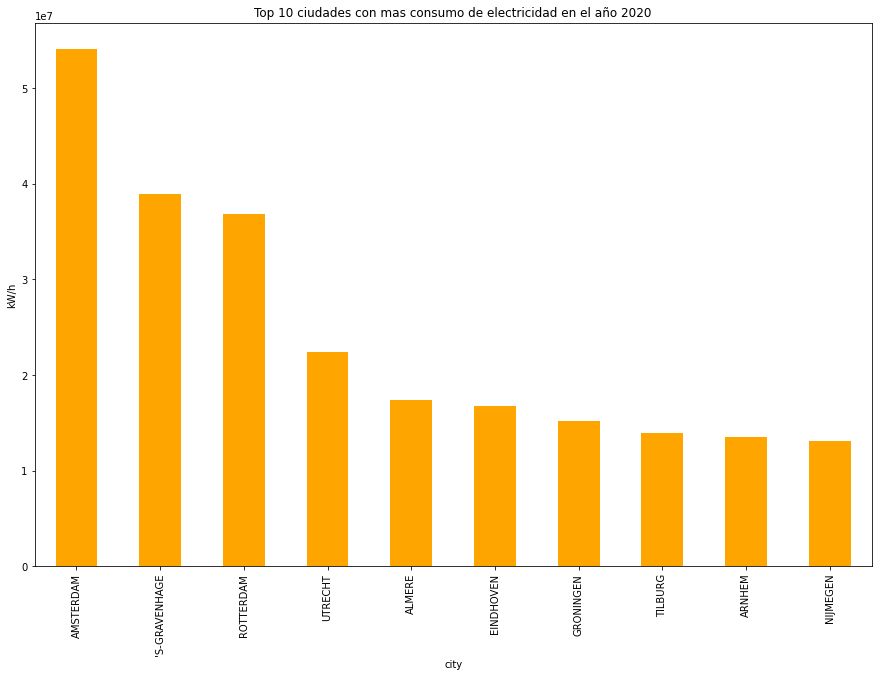

In [7]:
df_electricity_2020_consume['annual_consume'].plot(kind='bar', color = 'orange')
plt.title('Top 10 ciudades con mas consumo de electricidad en el año 2020')
plt.ylabel('kW/h')
plt.show()
#plt.lab

Datos Gas

In [8]:
df_gas_2020 = df_gas[df_gas['year'] == 2020].loc[:,["annual_consume","city"]]
df_gas_2020_consume = df_gas_2020.groupby('city').sum().sort_values(by='annual_consume',ascending=False).head(10)
df_gas_2020_consume


,annual_consume
city,
AMSTERDAM,19702249.87
'S-GRAVENHAGE,15504119.23
ROTTERDAM,12384871.48
EINDHOVEN,7459107.74
GRONINGEN,7243571.37
UTRECHT,6721954.06
HAARLEM,5376998.95
ENSCHEDE,5248303.80
NIJMEGEN,5072978.00


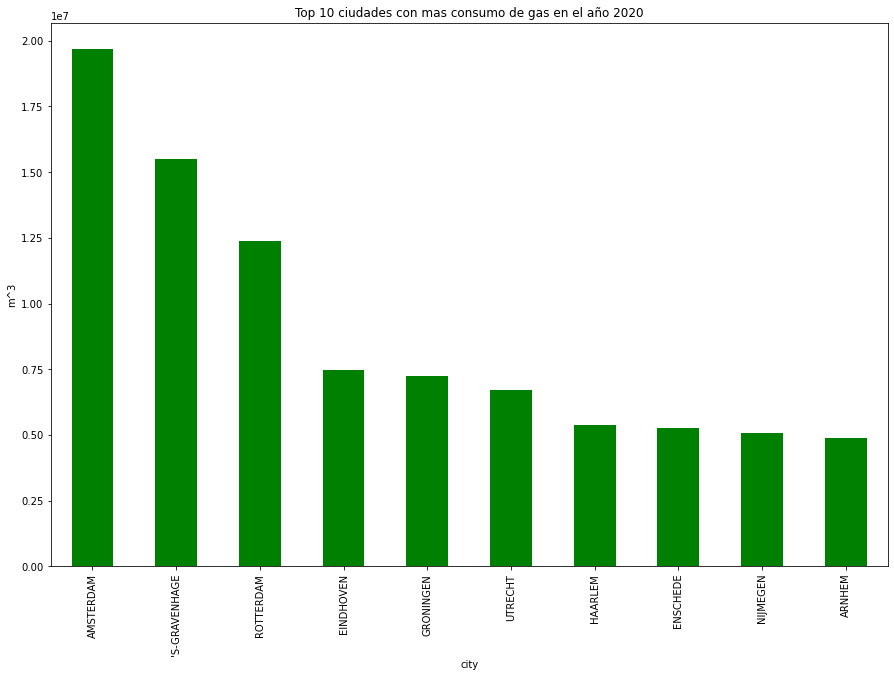

In [9]:
df_gas_2020_consume['annual_consume'].plot(kind='bar', color='green')
plt.title('Top 10 ciudades con mas consumo de gas en el año 2020')
plt.ylabel('m^3')
plt.show()

Se puede observar en los gráficos que no se repiten exactamente las mismas 10 ciudades. Sin embargo, las 3 ciudades con mayor consumo de electricidad también tienen el mayor consumo de gas. Tiene sentido que las 3 ciudades que consuman un recurso sean las mismas que más consume el otro, ya que deben ser estas las que concentren la mayor parte de la población del país

**PREGUNTA 2**

El grado de acaparamiento corresponde a las conexiones de cada empresa dividido por el número total de conexiones en el país en el año 2020

In [10]:
df_electric_2020_2 = df_electricity[df_electricity['year'] == 2020]
df_electric_2020_prom = df_electric_2020_2.groupby('net_manager').agg({
    'num_connections' : 'sum',
    'consume_per_conn' : 'sum'
})

total_conn = df_electric_2020_2['num_connections'].sum()

total_cons = df_electric_2020_2['consume_per_conn'].sum()

df_electric_2020_prom['grado de acaparamiento conexiones'] = df_electric_2020_prom[['num_connections']]*100/total_conn

df_electric_2020_prom['grado de acaparamiento consumo'] = df_electric_2020_prom[['consume_per_conn']]*100/total_cons

df_electric_2020_prom



,num_connections,consume_per_conn,grado de acaparamiento conexiones,grado de acaparamiento consumo
net_manager,,,,
coteq electricity,55307.0,5.783015e+05,0.656760,0.655881
enexis electricity,2666499.0,3.175402e+07,31.664148,36.013845
liander electricity,3505527.0,3.670862e+07,41.627439,41.633107
stedin electricity,2133441.0,1.853023e+07,25.334190,21.016070
westland-infra electricity,60419.0,6.005359e+05,0.717464,0.681098


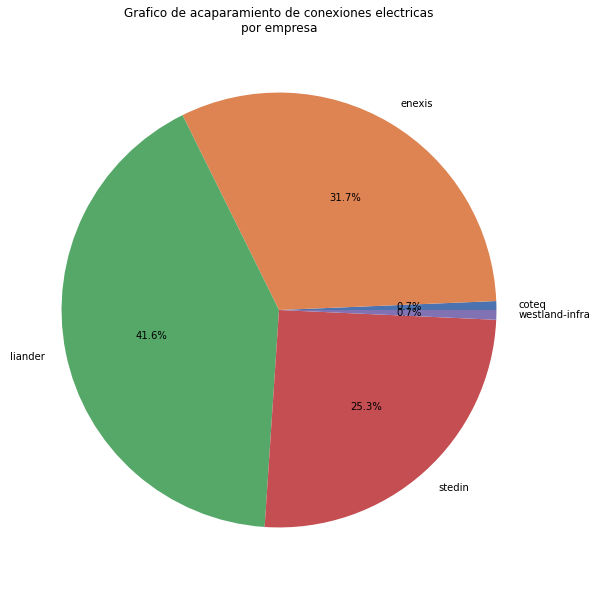

In [11]:
coteq = df_electric_2020_prom['grado de acaparamiento conexiones'][0]
enexis = df_electric_2020_prom['grado de acaparamiento conexiones'][1]
liander = df_electric_2020_prom['grado de acaparamiento conexiones'][2]
stedin = df_electric_2020_prom['grado de acaparamiento conexiones'][3]
westland = df_electric_2020_prom['grado de acaparamiento conexiones'][4]
ar = np.array([coteq, enexis, liander, stedin, westland])

labels = ["coteq", "enexis", "liander", "stedin", "westland-infra"]
plt.title("Grafico de acaparamiento de conexiones electricas\npor empresa")

colors = sn.color_palette('deep')[0:5]

plt.pie(ar, labels=labels, autopct="%.1f%%", colors=colors)
plt.show()




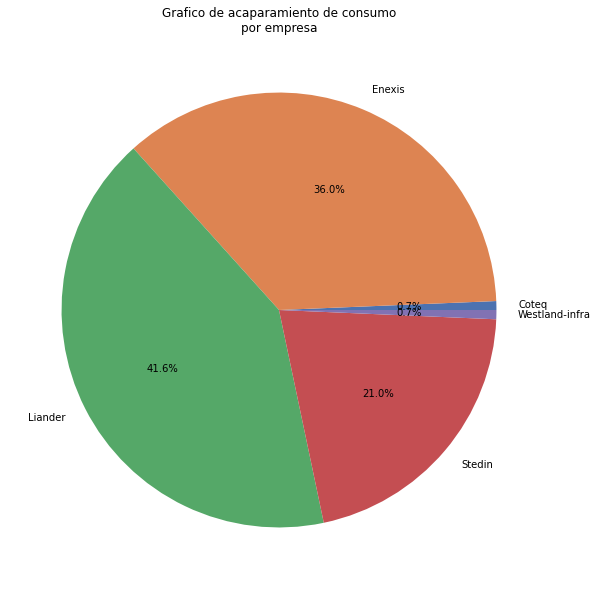

In [12]:
coteq = df_electric_2020_prom['grado de acaparamiento consumo'][0]
enexis = df_electric_2020_prom['grado de acaparamiento consumo'][1]
liander = df_electric_2020_prom['grado de acaparamiento consumo'][2]
stedin = df_electric_2020_prom['grado de acaparamiento consumo'][3]
westland = df_electric_2020_prom['grado de acaparamiento consumo'][4]
ar = np.array([coteq, enexis, liander, stedin, westland])

labels = ["Coteq", "Enexis", "Liander", "Stedin", "Westland-infra"]
plt.title("Grafico de acaparamiento de consumo\npor empresa")

colors = sn.color_palette('deep')[0:5]

plt.pie(ar, labels=labels, autopct="%.1f%%", colors=colors)
plt.show()

En los gráficos se puede observar que la compañía 'Liander' es la que más acapara el mercado de electricidad, tanto en número de conexiones (41.6%) como en consumo (41,6%). Junto a 'Enexis', que está en segundo lugar de ambas categorías, acaparan aproximadamente un 80 % del mercado de la electricidad.

**MEDIDAS DE TENDENCIA?**

Ahora se pasara a analizar los datos del gas

In [13]:
df_gas_2020_2 = df_gas[df_gas['year'] == 2020]
df_gas_2020_prom = df_gas_2020_2.groupby('net_manager').agg({
    'num_connections' : 'sum',
    'consume_per_conn' : 'sum'
})

total_conn = df_gas_2020_2['num_connections'].sum()

total_cons = df_gas_2020_2['consume_per_conn'].sum()

df_gas_2020_prom['grado de acaparamiento conexiones'] = df_gas_2020_prom[['num_connections']]*100/total_conn

df_gas_2020_prom['grado de acaparamiento consumo'] = df_gas_2020_prom[['consume_per_conn']]*100/total_cons

df_gas_2020_prom

,num_connections,consume_per_conn,grado de acaparamiento conexiones,grado de acaparamiento consumo
net_manager,,,,
coteq gas,145295.0,7.262738e+05,2.034836,2.228247
enexis gas,2299996.0,1.218012e+07,32.211124,37.369239
liander gas,2663902.0,1.152635e+07,37.307577,35.363440
stedin gas,1976782.0,7.958362e+06,27.684557,24.416676
westland-infra gas,54403.0,2.028641e+05,0.761906,0.622398


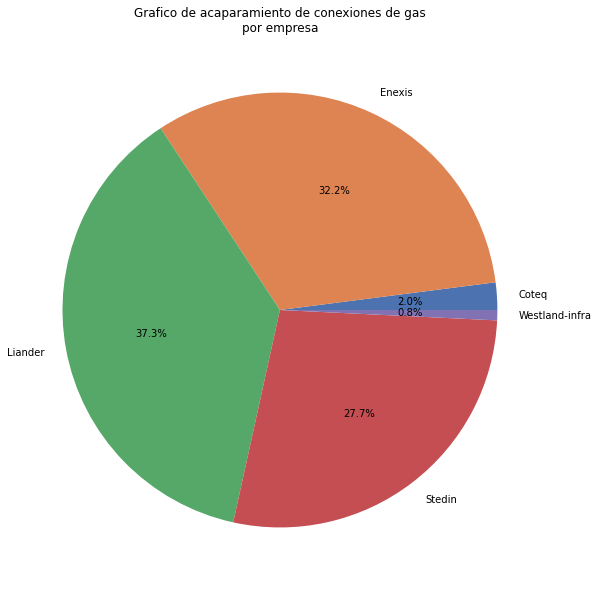

In [14]:
coteq = df_gas_2020_prom['grado de acaparamiento conexiones'][0]
enexis = df_gas_2020_prom['grado de acaparamiento conexiones'][1]
liander = df_gas_2020_prom['grado de acaparamiento conexiones'][2]
stedin = df_gas_2020_prom['grado de acaparamiento conexiones'][3]
westland = df_gas_2020_prom['grado de acaparamiento conexiones'][4]
ar = np.array([coteq, enexis, liander, stedin, westland])

labels = ["Coteq", "Enexis", "Liander", "Stedin", "Westland-infra"]
plt.title("Grafico de acaparamiento de conexiones de gas\npor empresa")

colors = sn.color_palette('deep')[0:5]

plt.pie(ar, labels=labels, autopct="%.1f%%", colors=colors)
plt.show()

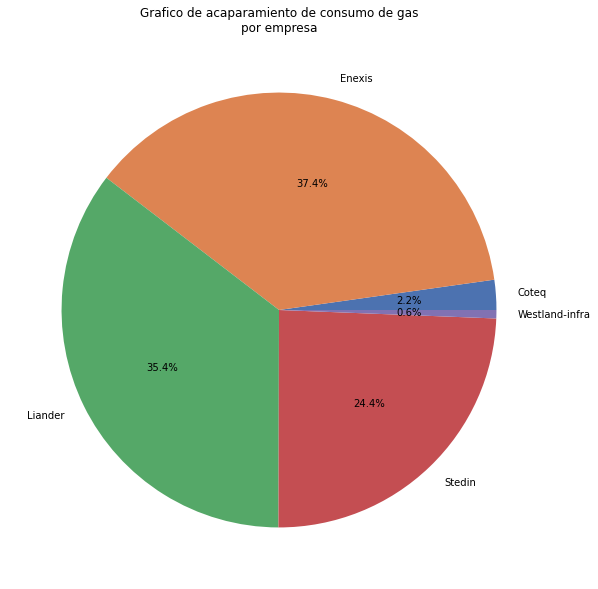

In [15]:
coteq = df_gas_2020_prom['grado de acaparamiento consumo'][0]
enexis = df_gas_2020_prom['grado de acaparamiento consumo'][1]
liander = df_gas_2020_prom['grado de acaparamiento consumo'][2]
stedin = df_gas_2020_prom['grado de acaparamiento consumo'][3]
westland = df_gas_2020_prom['grado de acaparamiento consumo'][4]
ar = np.array([coteq, enexis, liander, stedin, westland])

labels = ["Coteq", "Enexis", "Liander", "Stedin", "Westland-infra"]
plt.title("Grafico de acaparamiento de consumo de gas\npor empresa")

colors = sn.color_palette('deep')[0:5]

plt.pie(ar, labels=labels, autopct="%.1f%%", colors=colors)
plt.show()

En los gráficos se puede ver que, en términos de las conexiones del gas, 'Liander' vuelve a ser la compañía con mayor grado de acaparamiento con un 37,3%. Sin embargo, en términos de consumo, la compañía 'Enexis' es la compañía que más acapara, con un 37,4%. En suma, la compañía con más grado de acaparamiento en el mercado del gas es 'Liander'

La mediana no se puede sacar ya que los datos, aka las empresas, son cualitativos

In [16]:
df_e = df_electric_2020_2.groupby('net_manager')['consume_per_conn'].mean()
df_e

net_manager
coteq electricity             224.757667
enexis electricity            254.282387
liander electricity           255.130042
stedin electricity            214.624236
westland-infra electricity    234.859563
Name: consume_per_conn, dtype: float64

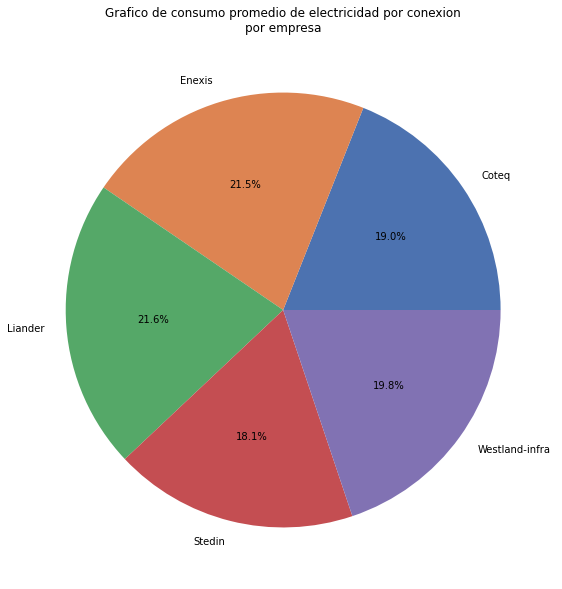

In [17]:
df_e[0]
coteq = df_e[0]
enexis = df_e[1]
liander = df_e[2]
stedin = df_e[3]
westland = df_e[4]
ar = np.array([coteq, enexis, liander, stedin, westland])

labels = ["Coteq", "Enexis", "Liander", "Stedin", "Westland-infra"]
plt.title("Grafico de consumo promedio de electricidad por conexion\npor empresa")

colors = sn.color_palette('deep')[0:5]

plt.pie(ar, labels=labels, autopct="%.1f%%", colors=colors)
plt.show()

Como podemos ver en el gráfico, 'Liander' es la compañía con más consumo de electricidad por conexión con un promedio porcentual de 21,6%, lo cual tiene sentido considerando que son la compañía que más acapara este mercado, sin embargo, no la diferencia la segunda compañía con más consumo por conexión, 'Enexis', es de solamente 0,01 puntos porcentuales. Esto llama la atención dado que la diferencia de acaparamiento de este mercado en términos de conexiones es de aproximadamente 10 puntos porcentuales, lo que nos lleva a concluir que 'Liander' consume menos energía por conexión que 'enexis', en promedio

In [18]:
df_g = df_gas_2020_2.groupby('net_manager')['consume_per_conn'].mean()
df_g

net_manager
coteq gas             105.425147
enexis gas            109.950673
liander gas            96.833199
stedin gas             89.826543
westland-infra gas     84.526718
Name: consume_per_conn, dtype: float64

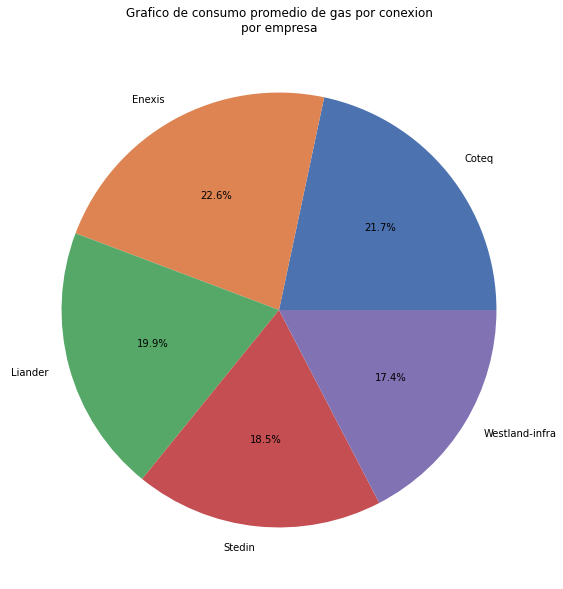

In [19]:
df_g[0]
coteq = df_g[0]
enexis = df_g[1]
liander = df_g[2]
stedin = df_g[3]
westland = df_g[4]
ar = np.array([coteq, enexis, liander, stedin, westland])

labels = ["Coteq", "Enexis", "Liander", "Stedin", "Westland-infra"]
plt.title("Grafico de consumo promedio de gas por conexion\npor empresa")

colors = sn.color_palette('deep')[0:5]

plt.pie(ar, labels=labels, autopct="%.1f%%", colors=colors)
plt.show()

De la misma manera, para el grafico del consumo promedio por conexión del gas, podemos ver que las compañías dominantes son 'Enexis' y 'Liander'. Sin embargo, se puede notar que 'Enexis' supera por 3 puntos porcentuales aproximadamente a 'Liander' siendo que acaparan menos el mercado de conexiones de gas. Lo que lleva a concluir que 'enexis' gasta más gas por conexión que 'Liander', aun teniendo una red de gas más pequeña

Pregunta 3

Consumo total: 88171706.93512323 [kW/h]
Sesgo: 81.99331891800466
Promedio: 244.76706891800467 [kW/h]
Mediana: 162.77375 [kW/h]
Moda: 0.0 [kW/h]


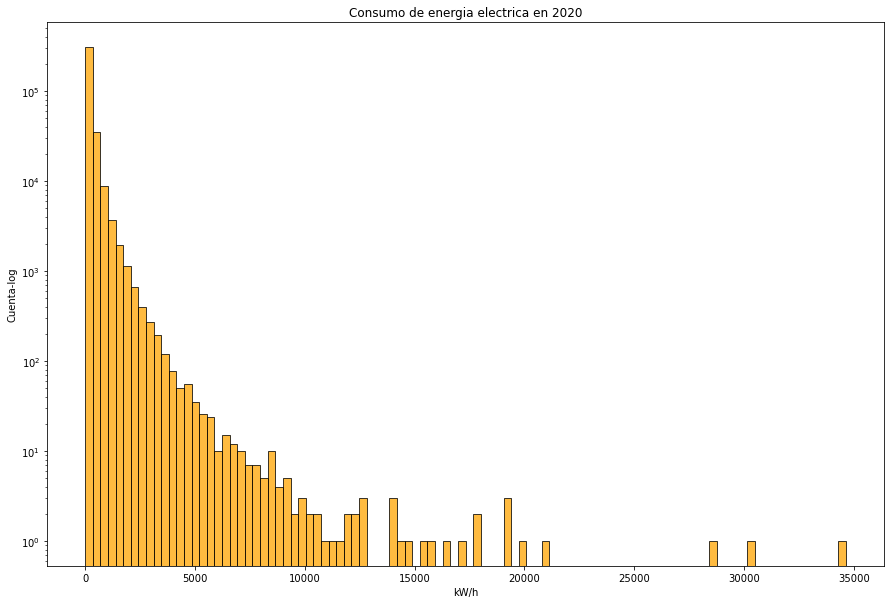

In [20]:
import statistics as stat
df_electric_2020_2['consume_per_conn']
sn.histplot(df_electric_2020_2['consume_per_conn'].dropna(), color="orange", bins=100)
plt.yscale('log') # Escala logarítmica en el eje Y produce una mucho más clara visualización
plt.title("Consumo de energia electrica en 2020") # "histplot", vemos con una mayor exactitud dónde se encuentran los datos
plt.xlabel("kW/h")
plt.ylabel("Cuenta-log")

consumo_total = df_electric_2020_2['consume_per_conn'].dropna().sum()


promedio = df_electric_2020_2['consume_per_conn'].dropna().mean()

mediana = stat.median(df_electric_2020_2['consume_per_conn'].dropna())

sesgo = promedio - mediana

moda = df_electric_2020_2['consume_per_conn'].dropna().mode()

moda = stat.mode(df_electric_2020_2['consume_per_conn'].dropna())

varianza = df_electric_2020_2['consume_per_conn'].dropna().var()

desv_stan = varianza**(1/2)

print('Consumo total:', consumo_total, '[kW/h]')
print('Sesgo:', sesgo)
print('Promedio:', promedio, '[kW/h]')
print('Mediana:', mediana, '[kW/h]')
print('Moda:', moda, '[kW/h]')



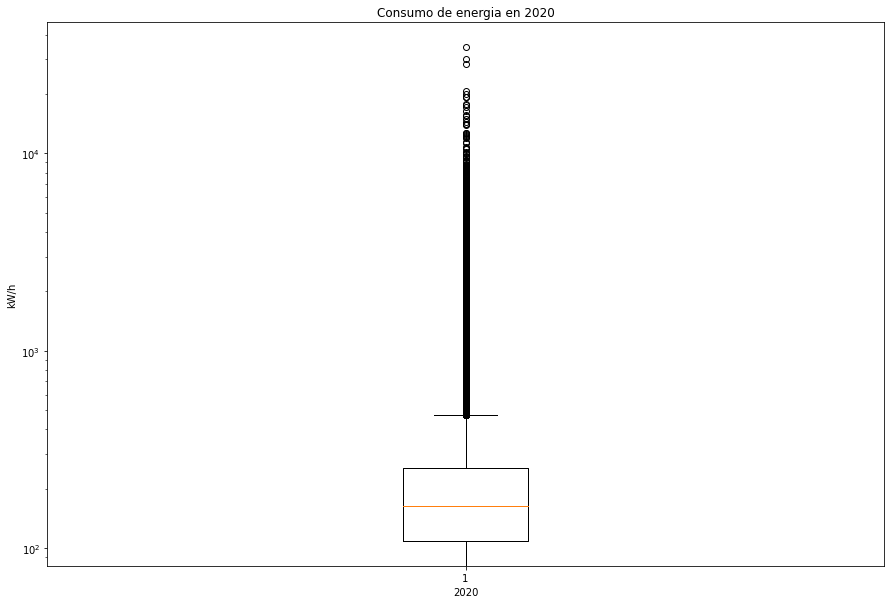

Varianza: 133803.46925285598 [kW/h]^2
Desviacion Estandar: 365.79156531125204 [kW/h]


In [21]:
plt.boxplot(df_electric_2020_2['consume_per_conn'].dropna())
plt.yscale('log')
plt.title('Consumo de energia en 2020')
plt.ylabel('kW/h')
plt.xlabel('2020')
plt.show()
print('Varianza:', varianza, '[kW/h]^2')
print('Desviacion Estandar:', desv_stan, '[kW/h]')

El consumo de electricidad en 2020 fue de 88171706.93 [kW/h], con un promedio de 244.76 [kW/h]. Al ver el histograma es claramente notable que presenta una asimetría positiva, en otras palabras, que la mayoría de los datos estarán por debajo del promedio. Esto tiene sentido ya que la mediana tiene un valor de 162.77[kW/h] y la moda corresponde al valor 0 [kW/h], llevando a la conclusión de que el consumo de energía en la red eléctrica de 2020 fue bajo. Cabe recalcar que los datos presentan un sesgo de 81.9. No obstante, los datos presentan una dispersión considerable, teniendo una varianza de 133803.46 [kW/h]^2 y una desviación estándar de 365.79 [kW/h], lo que significa que existen muchos datos que se denominan *outliers*. Esto es se puede verificar viendo el boxplot correspondiente a los datos del consumo de energía en 2020, siendo el registro más alto de consumo 34637 [kW/h], valor muy superior al promedio medido.



Consumo total: 32593961.92629205 [m^3]
Sesgo: 20.305823046020905
Promedio: 99.46371778286301 [m^3]
Mediana: 79.15789473684211 [m^3]
Moda: 0.0 [m^3]


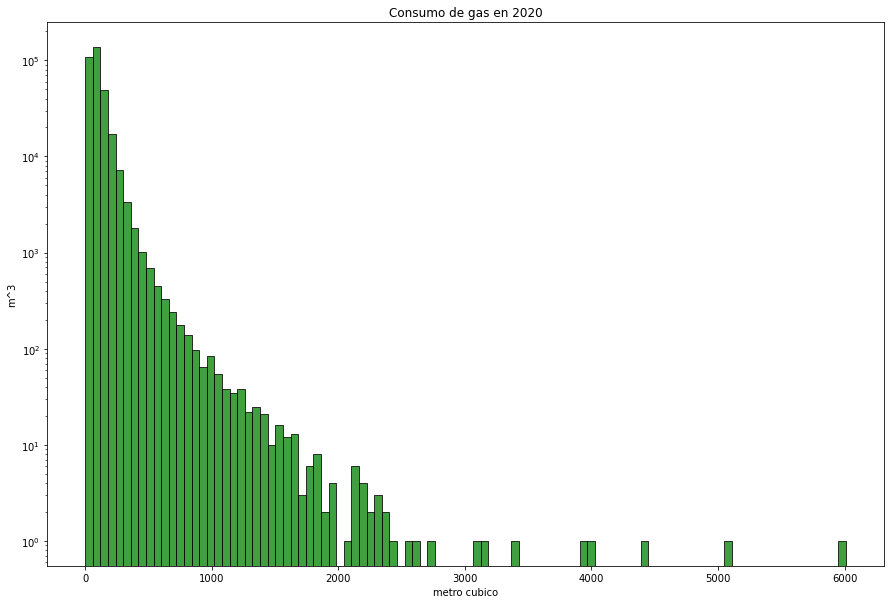

In [22]:
df_gas_2020_2['consume_per_conn']
sn.histplot(df_gas_2020_2['consume_per_conn'].dropna(), color="green", bins=100)
plt.yscale('log') # Escala logarítmica en el eje Y produce una mucho más clara visualización
plt.title("Consumo de gas en 2020") # "histplot", vemos con una mayor exactitud dónde se encuentran los datos
plt.xlabel("metro cubico")
plt.ylabel("m^3")

consumo_total = df_gas_2020_2['consume_per_conn'].dropna().sum()


promedio = df_gas_2020_2['consume_per_conn'].dropna().mean()

mediana = stat.median(df_gas_2020_2['consume_per_conn'].dropna())

sesgo = promedio - mediana

moda = stat.mode(df_gas_2020_2['consume_per_conn'].dropna())

varianza = df_gas_2020_2['consume_per_conn'].dropna().var()

desv_stan = varianza**(1/2)

print('Consumo total:', consumo_total, '[m^3]')
print('Sesgo:', sesgo)
print('Promedio:', promedio, '[m^3]')
print('Mediana:', mediana, '[m^3]')
print('Moda:', moda, '[m^3]')


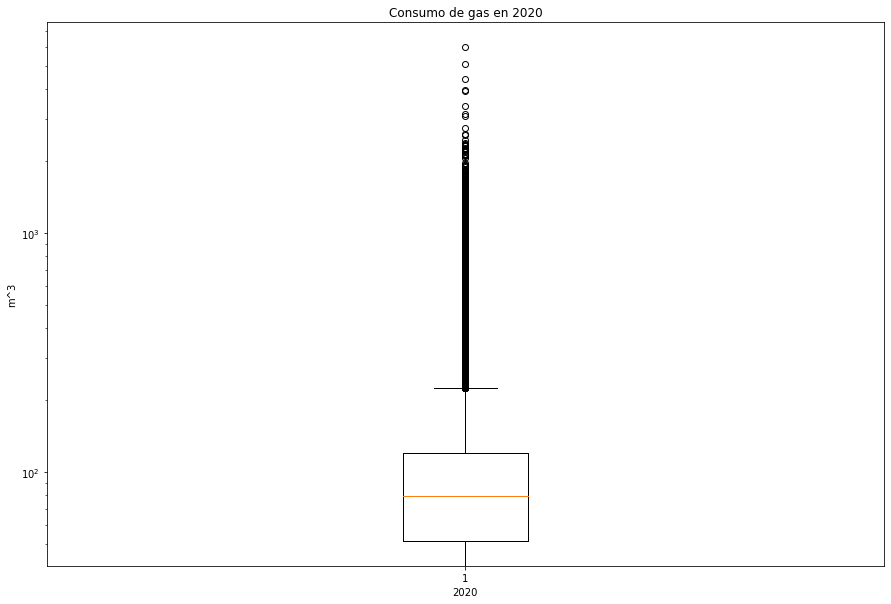

Varianza: 8819.999642532503 [m^3]^2
Desviacion Estandar: 93.91485315184443 [m^3]


In [23]:
plt.boxplot(df_gas_2020_2['consume_per_conn'].dropna())
plt.yscale('log')
plt.title('Consumo de gas en 2020')
plt.ylabel('m^3')
plt.xlabel('2020')
plt.show()
print('Varianza:', varianza, '[m^3]^2')
print('Desviacion Estandar:', desv_stan, '[m^3]')

El consumo total de gas en 2020 fue de 32593961.92 [m^3], con un promedio de 99.46 [m^3]. El histograma del consumo de gas de 2020, al igual que el de la electricidad, presenta una simetría positiva por lo que la mayoría de los datos se encuentran por debajo de la mediana, la cual tiene un valor de 79.15 [m^3]. El histograma presenta un sesgo con valor 20.30, lo cual lo hace mas un gráfico más exacto que el de la electricidad. Con respecto al consumo de gas, se puede decir que fue bajo, al igual que la electricidad, esto es reafirmado por la moda la cual es de 0 [m^3]. Al igual que los datos del consumo de energía eléctrica en 2020, los datos del gas presentan una alta dispersión con una varianza de 8819.99 [m^3]^2 y una desviación estándar de 93.91 [m^3]. Por último, en el boxplot se puede ver una gran presencia de datos *outliers* lo que lleva a deducir que hay zonas con un consumo muy alto de gas en comparación al resto del país

En suma, el consumo de ambas energías en la mayor parte del país fue bajo/normal, predominando en ambas energías el consumo nulo, presentando algunas zonas con consumos anormalmente altos

PREGUNTA 4


In [24]:
df_electricity_2020 = df_electricity[df_electricity['year']== 2020]

top_3_df_electricity_2020= df_electricity_2020.groupby('city').agg({"num_connections":"sum",'consume_per_conn':'sum'}).sort_values(by='num_connections',ascending=False).head(3).round(1)
top_last3_electricity_2020=df_electricity_2020.groupby('city').agg({"num_connections":"sum",'consume_per_conn':'sum'}).sort_values(by='num_connections',ascending=False).tail(3).round(1)

ciudades_vs_conexion=pd.concat([top_3_df_electricity_2020,top_last3_electricity_2020])
ciudades_vs_conexion

,num_connections,consume_per_conn
city,,
AMSTERDAM,526415.0,3101431.4
ROTTERDAM,311305.0,2055826.1
'S-GRAVENHAGE,278058.0,2176368.0
LANGEDIJK,10.0,7109.3
NIeuw Vennep,10.0,2640.7
RHEE,10.0,1599.7


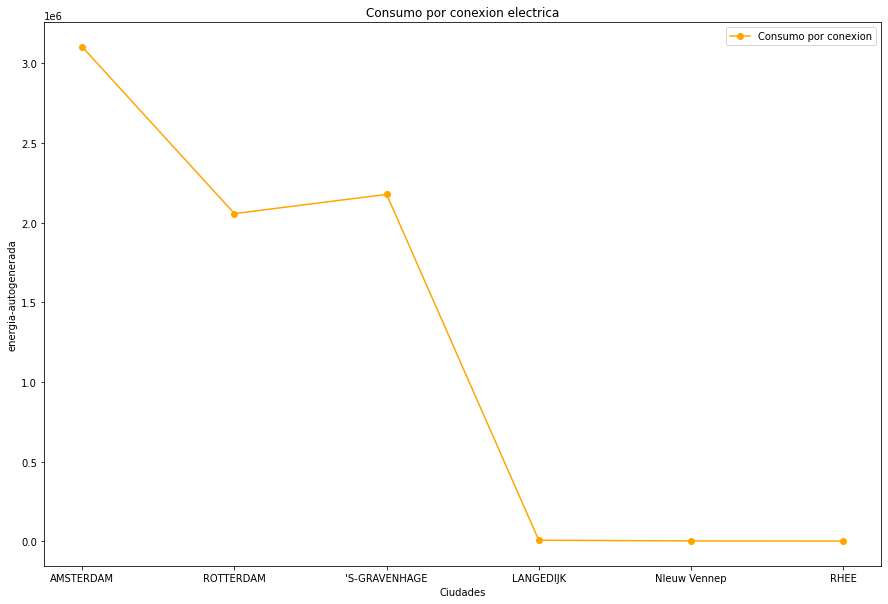

In [25]:
fig, ax = plt.subplots()
ax.plot(["AMSTERDAM", "ROTTERDAM", "'S-GRAVENHAGE","LANGEDIJK","NIeuw Vennep","RHEE"],ciudades_vs_conexion[:]['consume_per_conn'],label = 'Consumo por conexion', color='orange', marker='o')
ax.legend(loc = 'upper right')
plt.xlabel("Ciudades")
plt.ylabel("energia-autogenerada")
plt.title('Consumo por conexion electrica')
plt.show()


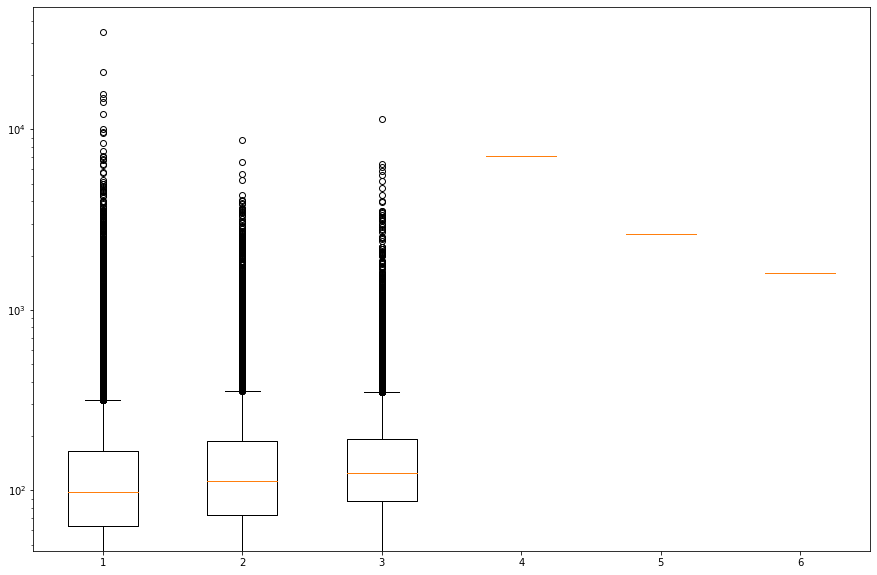

In [26]:
zona_amsterdam=df_electricity_2020[df_electricity_2020["city"]=="AMSTERDAM"].sort_values(by="consume_per_conn",ascending=False)
zona_rotterdam=df_electricity_2020[df_electricity_2020["city"]=="ROTTERDAM"].sort_values(by="consume_per_conn",ascending=False)
zona_s_gravenhage=df_electricity_2020[df_electricity_2020["city"]=="'S-GRAVENHAGE"].sort_values(by="consume_per_conn",ascending=False)
zona_langedijk=df_electricity_2020[df_electricity_2020["city"]=="LANGEDIJK"].sort_values(by="consume_per_conn",ascending=False)
zona_nieuw_vennep=df_electricity_2020[df_electricity_2020["city"]=="NIeuw Vennep"].sort_values(by="consume_per_conn",ascending=False)
zona_rhee=df_electricity_2020[df_electricity_2020["city"]=="RHEE"].sort_values(by="consume_per_conn",ascending=False)

plt.boxplot([zona_amsterdam["consume_per_conn"],zona_rotterdam["consume_per_conn"],zona_s_gravenhage["consume_per_conn"],zona_langedijk["consume_per_conn"],zona_nieuw_vennep["consume_per_conn"],zona_rhee["consume_per_conn"]])
plt.yscale("log")



Al ver la tabla si comparamos las primeras 3 ciudades con más número de conexiones, se puede observar que entre las dos primeras (Ámsterdam y Rotterdam) existe una diferencia de 215.110 conexiones y entre el consumo por conexión existe una diferencia de 1.045.605,3 kW/h. Ahora si comparamos Ámsterdam y 'S-Gravenhage (primera y tercera ciudad con más número de conexiones) estas tienen una diferencia de 248.330 conexiones y entre el consumo por conexión existe una diferencia de 925.063,4 kW/h, menor a la que Ámsterdam tenía con Rotterdam a pesar de que esta última posee 33.247 conexiones más. Lo mismo pasa al comparar las 3 ciudades con menos conexiones, estas 3 tienen el mismo número de conexiones, pero su consumo por conexión es diferente. En conclusión se puede llegar a que el número de conexiones si influirá en el consumo por conexión que tengan las ciudades, ya que entre más n° de conexiones gradualmente se tendrá más consumo, pero este último no dependerá totalmente del número de conexiones, sino más bien del uso que exista por cada conexión.


***Pregunta 5***

In [27]:
df_elec = df_electricity[["city","annual_consume","year","self_production"]]
df_elec20 = df_elec[df_elec["year"] == 2020]

cons2020 = df_elec20[["annual_consume"]].sum()
gen2020 = df_elec20[["self_production"]].sum()
print (cons2020,'\n', gen2020)
autoconsumo = (gen2020["self_production"]*100)/cons2020["annual_consume"]
print ('fracción de consumo auto-producido =', autoconsumo.round(1), '%')

annual_consume    1.492001e+09
dtype: float64 
 self_production    1.896263e+08
dtype: float64
fracción de consumo auto-producido = 12.7 %


In [28]:
df_distE20 = df_elec20.groupby('city').agg({
    'self_production' : 'sum',
    'annual_consume' : 'sum'
})
df_distE20['% consumo auto producido'] = (df_conelec['self_production']*100)/df_conelec['annual_consume']
df_distE20

NameError: name 'df_conelec' is not defined

In [ ]:
import statistics as stat

plt.boxplot([df_distE20['% consumo auto producido']])
plt.title('% auto producido por ciudad')
plt.ylabel('% autoproducción')
print (df_distE20['% consumo auto producido'].describe())

mediana = stat.median(df_distE20['% consumo auto producido'])
print ("mediana =", mediana)

PREGUNTA 6

,num_connections,self_production
city,,
AMSTERDAM,526415.0,1451576.7
ROTTERDAM,311305.0,1058606.9
'S-GRAVENHAGE,278058.0,1602601.4
LANGEDIJK,10.0,0.0
NIeuw Vennep,10.0,0.0
RHEE,10.0,1599.7


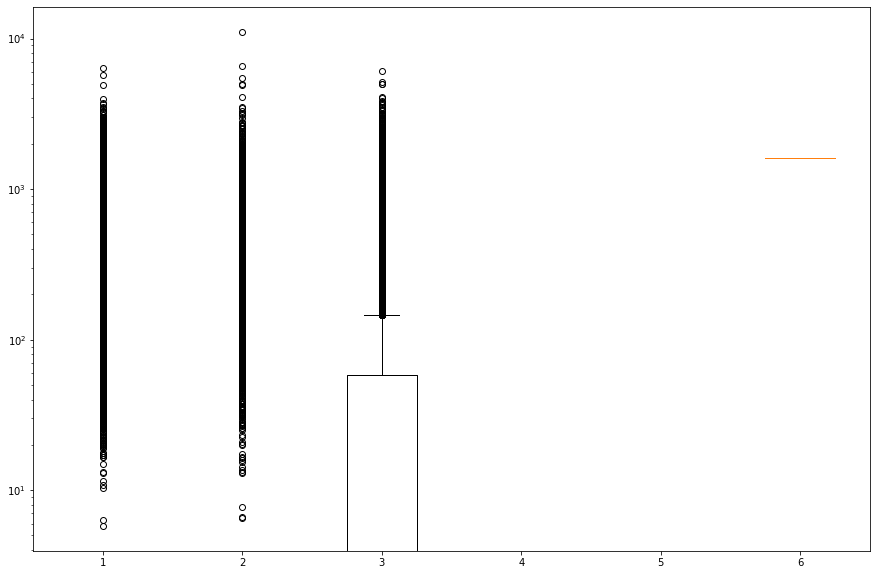

In [ ]:
df_electricity_2020 = df_electricity[df_electricity['year']== 2020]

ax.plot(["AMSTERDAM", "ROTTERDAM", "'S-GRAVENHAGE","LANGEDIJK","NIeuw Vennep","RHEE"])

zona_amsterdam=df_electricity_2020[df_electricity_2020["city"]=="AMSTERDAM"].sort_values(by="self_production",ascending=False)
zona_rotterdam=df_electricity_2020[df_electricity_2020["city"]=="ROTTERDAM"].sort_values(by="self_production",ascending=False)
zona_s_gravenhage=df_electricity_2020[df_electricity_2020["city"]=="'S-GRAVENHAGE"].sort_values(by="self_production",ascending=False)
zona_langedijk=df_electricity_2020[df_electricity_2020["city"]=="LANGEDIJK"].sort_values(by="self_production",ascending=False)
zona_nieuw_vennep=df_electricity_2020[df_electricity_2020["city"]=="NIeuw Vennep"].sort_values(by="self_production",ascending=False)
zona_rhee=df_electricity_2020[df_electricity_2020["city"]=="RHEE"].sort_values(by="self_production",ascending=False)




plt.boxplot([zona_amsterdam["self_production"],zona_rotterdam["self_production"],zona_s_gravenhage["self_production"],zona_langedijk["self_production"],zona_nieuw_vennep["self_production"],zona_rhee["self_production"]])
plt.yscale("log")



top_3_df_electricity_2020_2= df_electricity_2020.groupby('city').agg({"num_connections":"sum",'self_production':'sum'}).sort_values(by='num_connections',ascending=False).head(3).round(1)
top_last3_electricity_2020_2=df_electricity_2020.groupby('city').agg({"num_connections":"sum",'self_production':'sum'}).sort_values(by='num_connections',ascending=False).tail(3).round(1)

ciudades_vs_en_autogenerado=pd.concat([top_3_df_electricity_2020_2,top_last3_electricity_2020_2])
ciudades_vs_en_autogenerado

In [ ]:
df_electric_2020_2 = df_electricity[df_electricity['year'] == 2020]
df_conelec = df_electric_2020_2.groupby('city').agg({
    'num_connections' : 'sum',
    'self_production' : 'sum',
    'annual_consume' : 'sum'
}).sort_values(by='num_connections',ascending=False)

df_conelec['% consumo auto producido'] = (df_conelec['self_production']*100)/df_conelec['annual_consume']

df_top3 = df_conelec.head(3)
df_last3 = df_conelec.tail(3)

df_top3

In [ ]:
df_top3[["annual_consume","self_production"]].plot(kind='bar')

plt.ylabel('kW/h')
plt.title('consumo vs producción')


In [ ]:
df_last3[["annual_consume","self_production"]].plot(kind='bar')

plt.ylabel('kW/h')
plt.title('consumo vs producción')

In [ ]:
df_comparativa = pd.concat([df_top3, df_last3])
df_comparativa[["annual_consume","self_production"]].plot(kind='bar')
plt.yscale('log')
plt.ylabel('kW/h')
plt.title('consumo vs producción')

In [ ]:
df_comparativa

No se evidencia una dependencia entre el tamaño de la ciudad y el porcentaje de su consumo energetico que es auto producido, si bien las ciudades más grandes producen un volumen mayor de energía, si comparamos por ejemplo Ámsterdam con Rotterdam, las dos ciudades más grandes, la primera tiene sobre 200 mil conexiones más y la diferencia de porcentajes de autoproducción solo es de 0.19, al saltar al 3er puesto, con solo 33 mil conexiones menos, el porcentaje de auto producción sube casi 1,25%. La ciudad con mayor porcentaje de autoproducción del grupo pertenece a las ciudades de menor tamaño, llegando al 10% de auto producción, se nota cierta correlación inversa entre tamaño y porcentaje de auto producción, sin embargo de las 3 ciudades de menor tamaño, 2 no auto producen energía, por lo cual con este tamaño de muestra no se pueden obtener conclusiones robustas.

Pregunta 7


consumo anual vs cantidad generada 2020

In [30]:
df_electric_2020_self_prod = df_electric_2020_2.groupby('city').agg({
                            'net_annual_cons':'sum',
                            'self_production':'sum',
                            'num_connections':'sum'
                        })
df_electric_2020_self_prod.sample(10)

,net_annual_cons,self_production,num_connections
city,,,
LIPPENHUIZEN,129435.744000,31942.256000,627.0
BRITSUM,52012.005000,17962.995000,440.0
WORKUM,415556.354600,84710.645400,2627.0
LOENEN AAN DE VECHT,427209.586547,42219.003453,2133.0
TER IDZARD,25187.866600,9468.133400,158.0
SCHERPENZEEL GLD,877583.114799,114944.815201,4701.0
WOENSDRECHT,124199.205299,23146.354701,678.0
MEIJEL,676993.780394,137305.139606,2773.0
MILL,621135.540105,132353.309895,2780.0


In [ ]:
df_sample = df_electric_2020_self_prod.sample(20)
df_sample.plot(kind='bar')
#plt.yscale('log')
plt.title('Muestra consumo anual de ciudades ')
plt.show()

In [ ]:
df_sample.plot(kind='bar')
plt.yscale('log')
plt.title('Muestra consumo anual de ciudades ')
plt.show()

Tomando muestras aleatorias de 20 ciudades distintas, ya que la población de ciudades es demasiado grande para graficar en su completitud. Se puede ver que si existe cierta relación entre el consumo anual y la autoproducción de energía en una ciudad. Mientras más consumo halla, más autoproducción tendrá esa ciudad. De la misma manera con el número de conexiones. Cabe recalcar que la magnitud del valor de consumo anual es mucho mayor a la magnitud de los otros dos valores, como se puede ver en el grafico sin escala logarítmica del eje y, Por lo que la autoproducción no es lo suficientemente eficiente como para que una ciudad sea autosustentable

***PREGUNTA 8***

In [ ]:
df_e2020 = df_electricity[df_electricity['year'] == 2020]
df_e2019 = df_electricity[df_electricity['year'] == 2019]
df_e2018 = df_electricity[df_electricity['year'] == 2018]
df_e2017 = df_electricity[df_electricity['year'] == 2017]
df_e2016 = df_electricity[df_electricity['year'] == 2016]
df_e2015 = df_electricity[df_electricity['year'] == 2015]
df_e2014 = df_electricity[df_electricity['year'] == 2014]
df_e2013 = df_electricity[df_electricity['year'] == 2013]
df_e2012 = df_electricity[df_electricity['year'] == 2012]
df_e2011 = df_electricity[df_electricity['year'] == 2011]
df_e2010 = df_electricity[df_electricity['year'] == 2010]
df_e2009 = df_electricity[df_electricity['year'] == 2009]


df_e2020 = df_e2020[['city','num_connections','net_annual_cons']]
df_e2020 = df_e2020.groupby('city').sum('num_connections')
df_e2020 = df_e2020.sort_values(by='num_connections', ascending = False).head(10)


df_e2019 = df_e2019[['city','num_connections','net_annual_cons']]
df_e2019 = df_e2019.groupby('city').sum('num_connections')
df_e2019 = df_e2019.sort_values(by='num_connections', ascending = False).head(10)


df_e2018 = df_e2018[['city','num_connections','net_annual_cons']]
df_e2018 = df_e2018.groupby('city').sum('num_connections')
df_e2018 = df_e2018.sort_values(by='num_connections', ascending = False).head(10)


df_e2017 = df_e2017[['city','num_connections','net_annual_cons']]
df_e2017 = df_e2017.groupby('city').sum('num_connections')
df_e2017 = df_e2017.sort_values(by='num_connections', ascending = False).head(10)


df_e2016 = df_e2016[['city','num_connections','net_annual_cons']]
df_e2016 = df_e2016.groupby('city').sum('num_connections')
df_e2016 = df_e2016.sort_values(by='num_connections', ascending = False).head(10)

df_e2015 = df_e2015[['city','num_connections','net_annual_cons']]
df_e2015 = df_e2015.groupby('city').sum('num_connections')
df_e2015 = df_e2015.sort_values(by='num_connections', ascending = False).head(10)

df_e2014 = df_e2014[['city','num_connections','net_annual_cons']]
df_e2014 = df_e2014.groupby('city').sum('num_connections')
df_e2014 = df_e2014.sort_values(by='num_connections', ascending = False).head(10)

df_e2013 = df_e2013[['city','num_connections','net_annual_cons']]
df_e2013 = df_e2013.groupby('city').sum('num_connections')
df_e2013 = df_e2013.sort_values(by='num_connections', ascending = False).head(10)

df_e2012 = df_e2012[['city','num_connections','net_annual_cons']]
df_e2012 = df_e2012.groupby('city').sum('num_connections')
df_e2012 = df_e2012.sort_values(by='num_connections', ascending = False).head(10)

df_e2011 = df_e2011[['city','num_connections','net_annual_cons']]
df_e2011 = df_e2011.groupby('city').sum('num_connections')
df_e2011 = df_e2011.sort_values(by='num_connections', ascending = False).head(10)

df_e2010 = df_e2010[['city','num_connections','net_annual_cons']]
df_e2010 = df_e2010.groupby('city').sum('num_connections')
df_e2010 = df_e2010.sort_values(by='num_connections', ascending = False).head(10)

df_e2009 = df_e2009[['city','num_connections','net_annual_cons']]
df_e2009 = df_e2009.groupby('city').sum('num_connections')
df_e2009 = df_e2009.sort_values(by='num_connections', ascending = False).head(10)

Text(0, 0.5, 'kW/h')

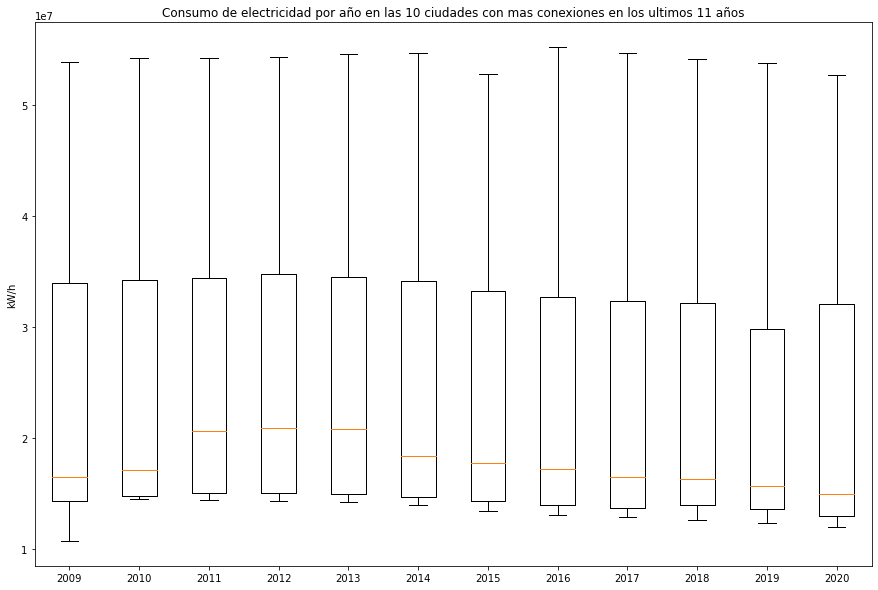

In [ ]:
plt.boxplot([df_e2009['net_annual_cons'] ,df_e2010['net_annual_cons'],df_e2011['net_annual_cons'],df_e2012['net_annual_cons'],df_e2013['net_annual_cons'],df_e2014['net_annual_cons'],df_e2015['net_annual_cons'],df_e2016['net_annual_cons'],df_e2017['net_annual_cons'],df_e2018['net_annual_cons'],df_e2019['net_annual_cons'],df_e2020['net_annual_cons']], labels=['2009','2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
plt.title('Consumo de electricidad por año en las 10 ciudades con mas conexiones en los ultimos 11 años')
plt.ylabel('kW/h')

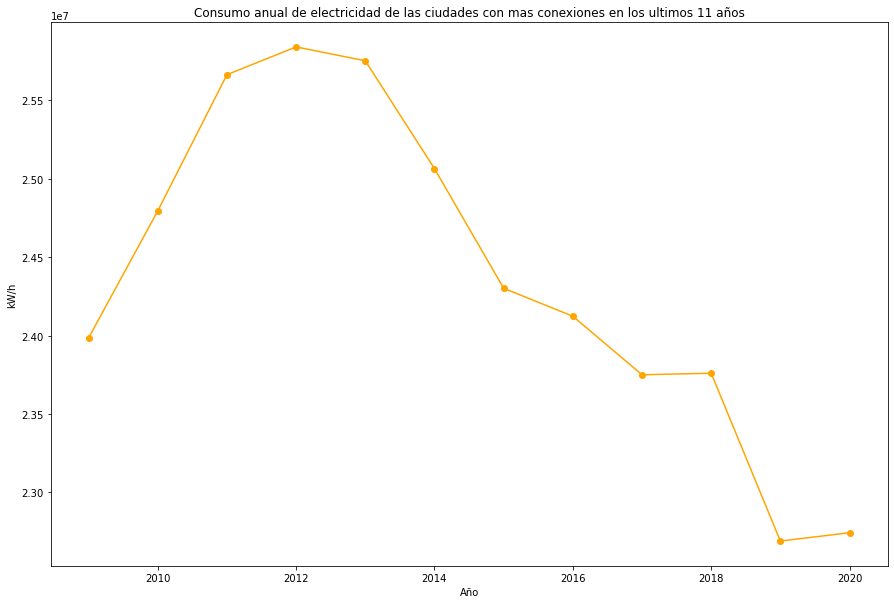

In [ ]:
p_2009 = df_e2009['net_annual_cons'].mean()
p_2010 = df_e2010['net_annual_cons'].mean()
p_2011 = df_e2011['net_annual_cons'].mean()
p_2012 = df_e2012['net_annual_cons'].mean()
p_2013 = df_e2013['net_annual_cons'].mean()
p_2014 = df_e2014['net_annual_cons'].mean()
p_2015 = df_e2015['net_annual_cons'].mean()
p_2016 = df_e2016['net_annual_cons'].mean()
p_2017 = df_e2017['net_annual_cons'].mean()
p_2018 = df_e2018['net_annual_cons'].mean()
p_2019 = df_e2019['net_annual_cons'].mean()
p_2020 = df_e2020['net_annual_cons'].mean()

year = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

ar_e = [p_2009, p_2010, p_2011, p_2012, p_2013, p_2014, p_2015, p_2016, p_2017, p_2018, p_2019, p_2020]

plt.plot(year,ar_e, color='orange', marker='o')
plt.xlabel('Año')
plt.ylabel('kW/h')
plt.title('Consumo promedio anual de electricidad de las ciudades con mas conexiones en los ultimos 11 años')
plt.show()



Como se puede ver, el consumo promedio de electricidad en el país experimento un incremento notable de 2009 a 2012, desde 2013 hasta el 2020 se ha visto una baja importante en este consumo promedio. Sin embargo, si bien el consumo promedio ha bajado bastante, la dispersión de los datos nos muestra que, dentro de las ciudades con más conexiones, siempre existen ciudades que tienen un consumo muy alto en comparación en las otras, como se puede ver en los bigotes superiores de los boxplots.

In [ ]:
df_g2020 = df_gas[df_gas['year'] == 2020]
df_g2019 = df_gas[df_gas['year'] == 2019]
df_g2018 = df_gas[df_gas['year'] == 2018]
df_g2017 = df_gas[df_gas['year'] == 2017]
df_g2016 = df_gas[df_gas['year'] == 2016]
df_g2015 = df_gas[df_gas['year'] == 2015]
df_g2014 = df_gas[df_gas['year'] == 2014]
df_g2013 = df_gas[df_gas['year'] == 2013]
df_g2012 = df_gas[df_gas['year'] == 2012]
df_g2011 = df_gas[df_gas['year'] == 2011]
df_g2010 = df_gas[df_gas['year'] == 2010]
df_g2009 = df_gas[df_gas['year'] == 2009]


df_g2020 = df_g2020[['city','num_connections','net_annual_cons']]
df_g2020 = df_g2020.groupby('city').sum('num_connections')
df_g2020 = df_g2020.sort_values(by='num_connections', ascending = False).head(10)


df_g2019 = df_g2019[['city','num_connections','net_annual_cons']]
df_g2019 = df_g2019.groupby('city').sum('num_connections')
df_g2019 = df_g2019.sort_values(by='num_connections', ascending = False).head(10)


df_g2018 = df_g2018[['city','num_connections','net_annual_cons']]
df_g2018 = df_g2018.groupby('city').sum('num_connections')
df_g2018 = df_g2018.sort_values(by='num_connections', ascending = False).head(10)


df_g2017 = df_g2017[['city','num_connections','net_annual_cons']]
df_g2017 = df_g2017.groupby('city').sum('num_connections')
df_g2017 = df_g2017.sort_values(by='num_connections', ascending = False).head(10)


df_g2016 = df_g2016[['city','num_connections','net_annual_cons']]
df_g2016 = df_g2016.groupby('city').sum('num_connections')
df_g2016 = df_g2016.sort_values(by='num_connections', ascending = False).head(10)

df_g2015 = df_g2015[['city','num_connections','net_annual_cons']]
df_g2015 = df_g2015.groupby('city').sum('num_connections')
df_g2015 = df_g2015.sort_values(by='num_connections', ascending = False).head(10)

df_g2014 = df_g2014[['city','num_connections','net_annual_cons']]
df_g2014 = df_g2014.groupby('city').sum('num_connections')
df_g2014 = df_g2014.sort_values(by='num_connections', ascending = False).head(10)

df_g2013 = df_g2013[['city','num_connections','net_annual_cons']]
df_g2013 = df_g2013.groupby('city').sum('num_connections')
df_g2013 = df_g2013.sort_values(by='num_connections', ascending = False).head(10)

df_g2012 = df_g2012[['city','num_connections','net_annual_cons']]
df_g2012 = df_g2012.groupby('city').sum('num_connections')
df_g2012 = df_g2012.sort_values(by='num_connections', ascending = False).head(10)

df_g2011 = df_g2011[['city','num_connections','net_annual_cons']]
df_g2011 = df_g2011.groupby('city').sum('num_connections')
df_g2011 = df_g2011.sort_values(by='num_connections', ascending = False).head(10)

df_g2010 = df_g2010[['city','num_connections','net_annual_cons']]
df_g2010 = df_g2010.groupby('city').sum('num_connections')
df_g2010 = df_g2010.sort_values(by='num_connections', ascending = False).head(10)

df_g2009 = df_g2009[['city','num_connections','net_annual_cons']]
df_g2009 = df_g2009.groupby('city').sum('num_connections')
df_g2009 = df_g2009.sort_values(by='num_connections', ascending = False).head(10)

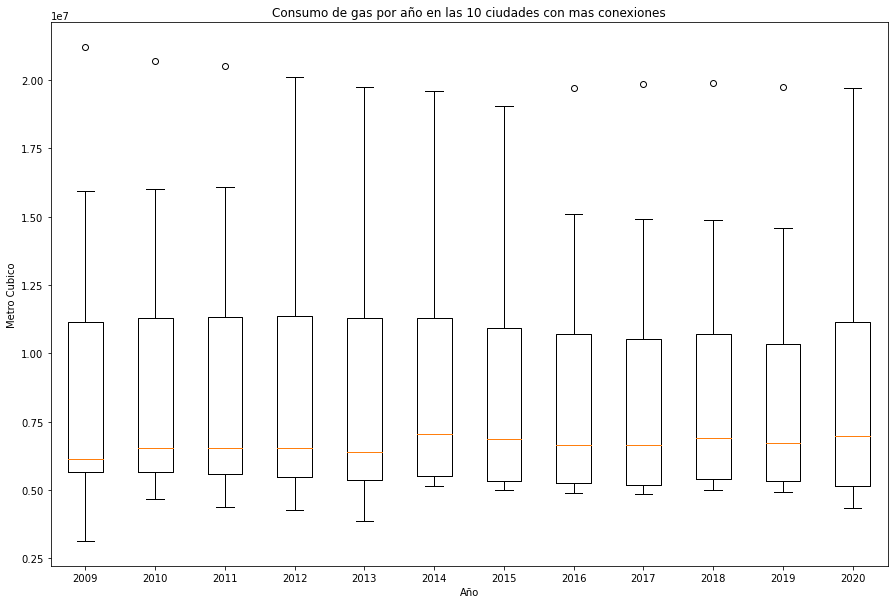

In [ ]:
plt.boxplot([df_g2009['net_annual_cons'] ,df_g2010['net_annual_cons'],df_g2011['net_annual_cons'],df_g2012['net_annual_cons'],df_g2013['net_annual_cons'],df_g2014['net_annual_cons'],df_g2015['net_annual_cons'],df_g2016['net_annual_cons'],df_g2017['net_annual_cons'],df_g2018['net_annual_cons'],df_g2019['net_annual_cons'],df_g2020['net_annual_cons']], labels=['2009','2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
plt.title('Consumo de gas por año en las 10 ciudades con mas conexiones')
plt.ylabel('Metro Cubico')
plt.xlabel('Año')
plt.show()

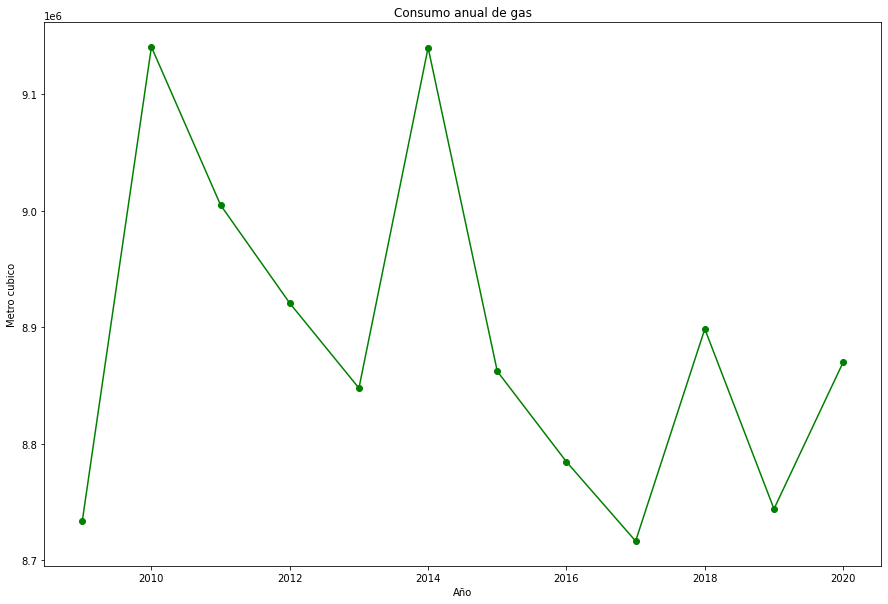

In [ ]:
p_2009 = df_g2009['net_annual_cons'].mean()
p_2010 = df_g2010['net_annual_cons'].mean()
p_2011 = df_g2011['net_annual_cons'].mean()
p_2012 = df_g2012['net_annual_cons'].mean()
p_2013 = df_g2013['net_annual_cons'].mean()
p_2014 = df_g2014['net_annual_cons'].mean()
p_2015 = df_g2015['net_annual_cons'].mean()
p_2016 = df_g2016['net_annual_cons'].mean()
p_2017 = df_g2017['net_annual_cons'].mean()
p_2018 = df_g2018['net_annual_cons'].mean()
p_2019 = df_g2019['net_annual_cons'].mean()
p_2020 = df_g2020['net_annual_cons'].mean()

year = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

ar = [p_2009, p_2010, p_2011, p_2012, p_2013, p_2014, p_2015, p_2016, p_2017, p_2018, p_2019, p_2020]

plt.plot(year,ar, color='green', marker='o')
plt.xlabel('Año')
plt.ylabel('Metro cubico')
plt.title('Consumo anual de gas')
plt.show()

El consumo promedio del gas a tenido una fluctuación importante desde 2009, llegando a sus valores más altos en 2010 y 2014, año donde el consumo promedio empezaría a bajar bruscamente hasta 2017, donde volvió a un comportamiento similar a los años anteriores a 2014. En 2020 el consumo promedio volvió a subir, sin embargo, debido a la volatilidad de los registros es complicado hacer una predicción fiable sobre el consumo futuro del gas.
Con respecto a la dispersión del consumo a lo largo de los años, se puede ver que, al igual que en la electricidad, siempre hay ciudades con un registro muy elevado en comparación a las otras, dentro de las 10 con más conexiones, pero en el gas es más la diferencia entre la mediana y la ciudad con mayor consumo, ya que se puede ver que esta vez son catalogados como *outliers* los mayores datos, cosa que en la electricidad no ocurría

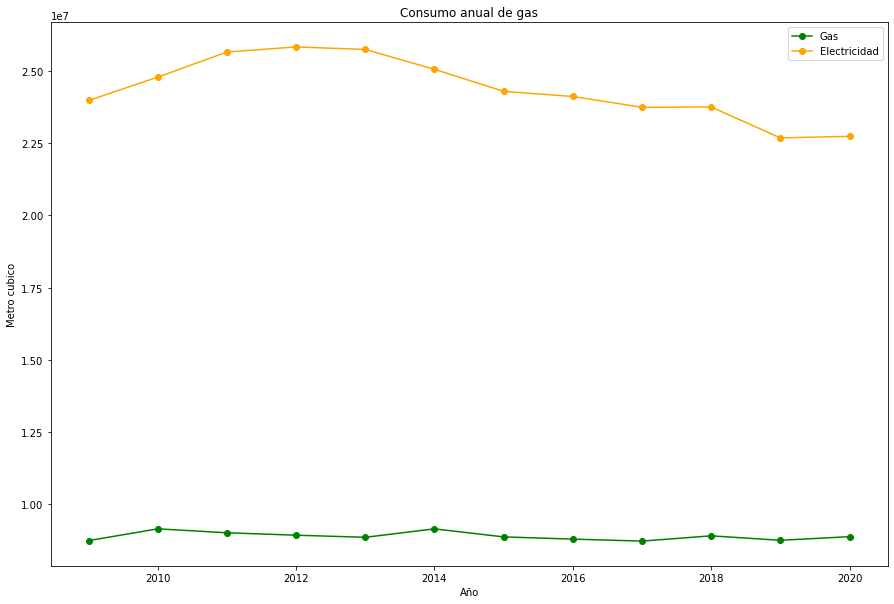

In [ ]:
plt.plot(year,ar, color='green', marker='o')
plt.plot(year,ar_e, color='orange', marker='o')
plt.xlabel('Año')
plt.ylabel('Metro cubico')
plt.legend(['Gas','Electricidad'])
plt.title('Consumo anual de gas')
plt.show()

Podemos ver que el consumo de electricidad a presentado una baja considerable mientras que el consumo del gas se ha mantenido prácticamente constante

***PREGUNTA 9***

In [ ]:
df_e2020 = df_electricity[df_electricity['year'] == 2020]
df_e2019 = df_electricity[df_electricity['year'] == 2019]
df_e2018 = df_electricity[df_electricity['year'] == 2018]
df_e2017 = df_electricity[df_electricity['year'] == 2017]
df_e2016 = df_electricity[df_electricity['year'] == 2016]
df_e2015 = df_electricity[df_electricity['year'] == 2015]
df_e2014 = df_electricity[df_electricity['year'] == 2014]
df_e2013 = df_electricity[df_electricity['year'] == 2013]
df_e2012 = df_electricity[df_electricity['year'] == 2012]
df_e2011 = df_electricity[df_electricity['year'] == 2011]
df_e2010 = df_electricity[df_electricity['year'] == 2010]
df_e2009 = df_electricity[df_electricity['year'] == 2009]


df_e2020 = df_e2020[['city','num_connections','self_production']]
df_e2020 = df_e2020.groupby('city').sum('num_connections')
df_e2020 = df_e2020.sort_values(by='num_connections', ascending = False).head(10)


df_e2019 = df_e2019[['city','num_connections','self_production']]
df_e2019 = df_e2019.groupby('city').sum('num_connections')
df_e2019 = df_e2019.sort_values(by='num_connections', ascending = False).head(10)


df_e2018 = df_e2018[['city','num_connections','self_production']]
df_e2018 = df_e2018.groupby('city').sum('num_connections')
df_e2018 = df_e2018.sort_values(by='num_connections', ascending = False).head(10)


df_e2017 = df_e2017[['city','num_connections','self_production']]
df_e2017 = df_e2017.groupby('city').sum('num_connections')
df_e2017 = df_e2017.sort_values(by='num_connections', ascending = False).head(10)


df_e2016 = df_e2016[['city','num_connections','self_production']]
df_e2016 = df_e2016.groupby('city').sum('num_connections')
df_e2016 = df_e2016.sort_values(by='num_connections', ascending = False).head(10)

df_e2015 = df_e2015[['city','num_connections','self_production']]
df_e2015 = df_e2015.groupby('city').sum('num_connections')
df_e2015 = df_e2015.sort_values(by='num_connections', ascending = False).head(10)

df_e2014 = df_e2014[['city','num_connections','self_production']]
df_e2014 = df_e2014.groupby('city').sum('num_connections')
df_e2014 = df_e2014.sort_values(by='num_connections', ascending = False).head(10)

df_e2013 = df_e2013[['city','num_connections','self_production']]
df_e2013 = df_e2013.groupby('city').sum('num_connections')
df_e2013 = df_e2013.sort_values(by='num_connections', ascending = False).head(10)

df_e2012 = df_e2012[['city','num_connections','self_production']]
df_e2012 = df_e2012.groupby('city').sum('num_connections')
df_e2012 = df_e2012.sort_values(by='num_connections', ascending = False).head(10)

df_e2011 = df_e2011[['city','num_connections','self_production']]
df_e2011 = df_e2011.groupby('city').sum('num_connections')
df_e2011 = df_e2011.sort_values(by='num_connections', ascending = False).head(10)

df_e2010 = df_e2010[['city','num_connections','self_production']]
df_e2010 = df_e2010.groupby('city').sum('num_connections')
df_e2010 = df_e2010.sort_values(by='num_connections', ascending = False).head(10)

df_e2009 = df_e2009[['city','num_connections','self_production']]
df_e2009 = df_e2009.groupby('city').sum('num_connections')
df_e2009 = df_e2009.sort_values(by='num_connections', ascending = False).head(10)

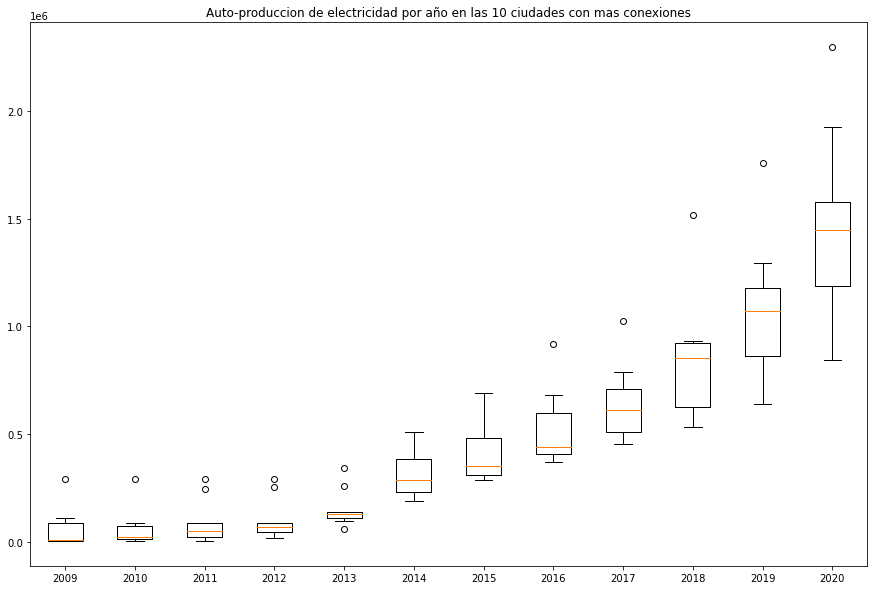

In [ ]:
plt.boxplot([df_e2009['self_production'] ,df_e2010['self_production'],df_e2011['self_production'],df_e2012['self_production'],df_e2013['self_production'],df_e2014['self_production'],df_e2015['self_production'],df_e2016['self_production'],df_e2017['self_production'],df_e2018['self_production'],df_e2019['self_production'],df_e2020['self_production']], labels=['2009','2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
plt.title('Auto-produccion de electricidad por año en las 10 ciudades con mas conexiones')
plt.show()
#plt.yscale('log')

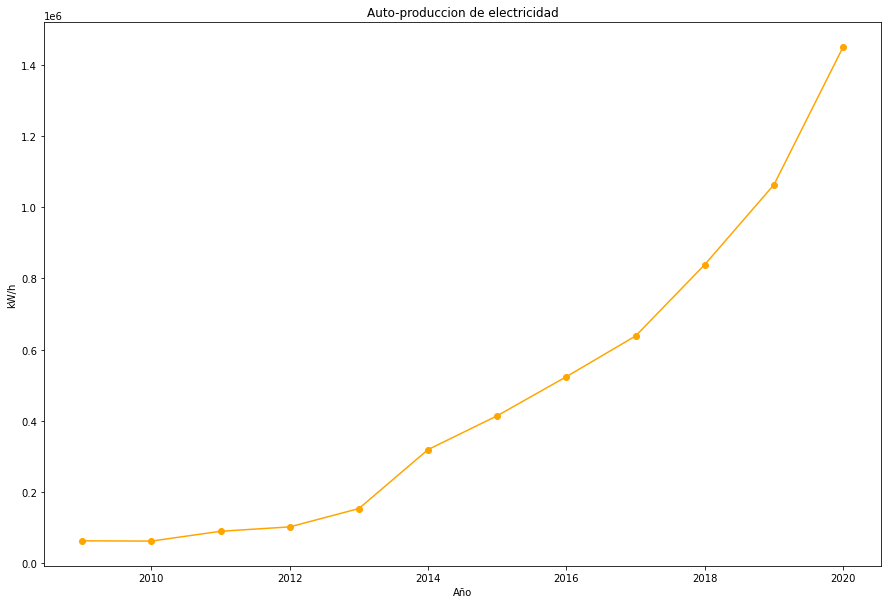

In [ ]:
p_2009 = df_e2009['self_production'].mean()
p_2010 = df_e2010['self_production'].mean()
p_2011 = df_e2011['self_production'].mean()
p_2012 = df_e2012['self_production'].mean()
p_2013 = df_e2013['self_production'].mean()
p_2014 = df_e2014['self_production'].mean()
p_2015 = df_e2015['self_production'].mean()
p_2016 = df_e2016['self_production'].mean()
p_2017 = df_e2017['self_production'].mean()
p_2018 = df_e2018['self_production'].mean()
p_2019 = df_e2019['self_production'].mean()
p_2020 = df_e2020['self_production'].mean()

year = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

ar = [p_2009, p_2010, p_2011, p_2012, p_2013, p_2014, p_2015, p_2016, p_2017, p_2018, p_2019, p_2020]

plt.plot(year,ar, color='orange', marker='o')
plt.xlabel('Año')
plt.ylabel('kW/h')
plt.title('Auto-produccion de electricidad')
plt.show()

Se puede apreciar un aumento considerable en la autoproducción de energía eléctrica por parte de la población de las 10 ciudades con más conexiones en los últimos años. Cabe recalcar la presencia de datos *outliers* desde 2016 lo que nos dice que las ciudades tienen una fuerte iniciativa por fomentar la autoproducción de energía eléctrica. Además, se puede notar una creciente dispersión en los datos desde 2013. Esto se puede deber a que hay ciudades que avanzan tecnológicamente más rápido que otras, por tanto, las ciudades más 'arcaicas' se quedan estancadas en cierto nivel de autoproducción de electricidad, mientras que las otras avanzan a un ritmo más rápido.

In [ ]:
df_g2020 = df_gas[df_gas['year'] == 2020]
df_g2019 = df_gas[df_gas['year'] == 2019]
df_g2018 = df_gas[df_gas['year'] == 2018]
df_g2017 = df_gas[df_gas['year'] == 2017]
df_g2016 = df_gas[df_gas['year'] == 2016]
df_g2015 = df_gas[df_gas['year'] == 2015]
df_g2014 = df_gas[df_gas['year'] == 2014]
df_g2013 = df_gas[df_gas['year'] == 2013]
df_g2012 = df_gas[df_gas['year'] == 2012]
df_g2011 = df_gas[df_gas['year'] == 2011]
df_g2010 = df_gas[df_gas['year'] == 2010]
df_g2009 = df_gas[df_gas['year'] == 2009]


df_g2020 = df_g2020[['city','num_connections','self_production']]
df_g2020 = df_g2020.groupby('city').sum('num_connections')
df_g2020 = df_g2020.sort_values(by='num_connections', ascending = False).head(10)


df_g2019 = df_g2019[['city','num_connections','self_production']]
df_g2019 = df_g2019.groupby('city').sum('num_connections')
df_g2019 = df_g2019.sort_values(by='num_connections', ascending = False).head(10)


df_g2018 = df_g2018[['city','num_connections','self_production']]
df_g2018 = df_g2018.groupby('city').sum('num_connections')
df_g2018 = df_g2018.sort_values(by='num_connections', ascending = False).head(10)


df_g2017 = df_g2017[['city','num_connections','self_production']]
df_g2017 = df_g2017.groupby('city').sum('num_connections')
df_g2017 = df_g2017.sort_values(by='num_connections', ascending = False).head(10)


df_g2016 = df_g2016[['city','num_connections','self_production']]
df_g2016 = df_g2016.groupby('city').sum('num_connections')
df_g2016 = df_g2016.sort_values(by='num_connections', ascending = False).head(10)

df_g2015 = df_g2015[['city','num_connections','self_production']]
df_g2015 = df_g2015.groupby('city').sum('num_connections')
df_g2015 = df_g2015.sort_values(by='num_connections', ascending = False).head(10)

df_g2014 = df_g2014[['city','num_connections','self_production']]
df_g2014 = df_g2014.groupby('city').sum('num_connections')
df_g2014 = df_g2014.sort_values(by='num_connections', ascending = False).head(10)

df_g2013 = df_g2013[['city','num_connections','self_production']]
df_g2013 = df_g2013.groupby('city').sum('num_connections')
df_g2013 = df_g2013.sort_values(by='num_connections', ascending = False).head(10)

df_g2012 = df_g2012[['city','num_connections','self_production']]
df_g2012 = df_g2012.groupby('city').sum('num_connections')
df_g2012 = df_g2012.sort_values(by='num_connections', ascending = False).head(10)

df_g2011 = df_g2011[['city','num_connections','self_production']]
df_g2011 = df_g2011.groupby('city').sum('num_connections')
df_g2011 = df_g2011.sort_values(by='num_connections', ascending = False).head(10)

df_g2010 = df_g2010[['city','num_connections','self_production']]
df_g2010 = df_g2010.groupby('city').sum('num_connections')
df_g2010 = df_g2010.sort_values(by='num_connections', ascending = False).head(10)

df_g2009 = df_g2009[['city','num_connections','self_production']]
df_g2009 = df_g2009.groupby('city').sum('num_connections')
df_g2009 = df_g2009.sort_values(by='num_connections', ascending = False).head(10)

Text(0, 0.5, 'Auto-produccion de gas')

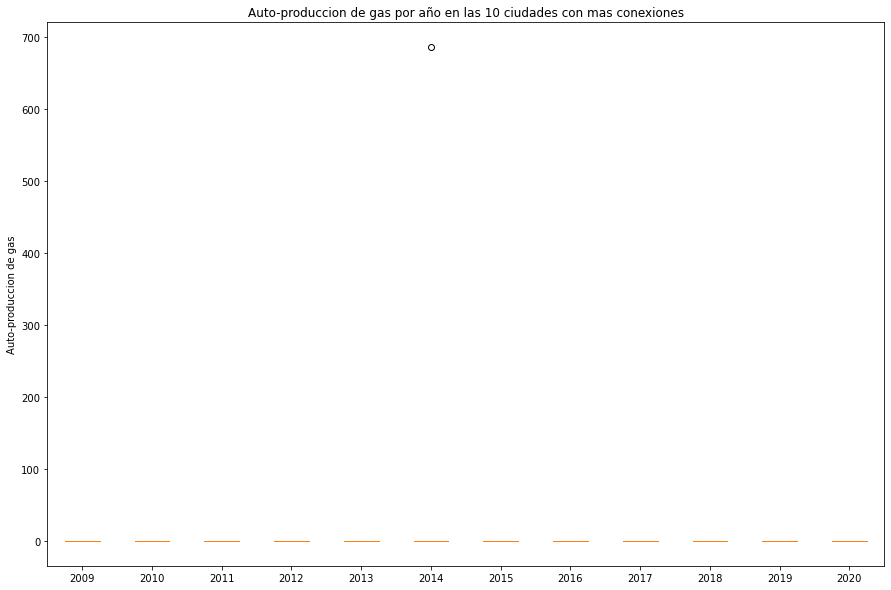

In [ ]:
plt.boxplot([df_g2009['self_production'] ,df_g2010['self_production'],df_g2011['self_production'],df_g2012['self_production'],df_g2013['self_production'],df_g2014['self_production'],df_g2015['self_production'],df_g2016['self_production'],df_g2017['self_production'],df_g2018['self_production'],df_g2019['self_production'],df_g2020['self_production']], labels=['2009','2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
plt.title('Auto-produccion de gas por año en las 10 ciudades con mas conexiones')
plt.ylabel('Auto-produccion de gas')


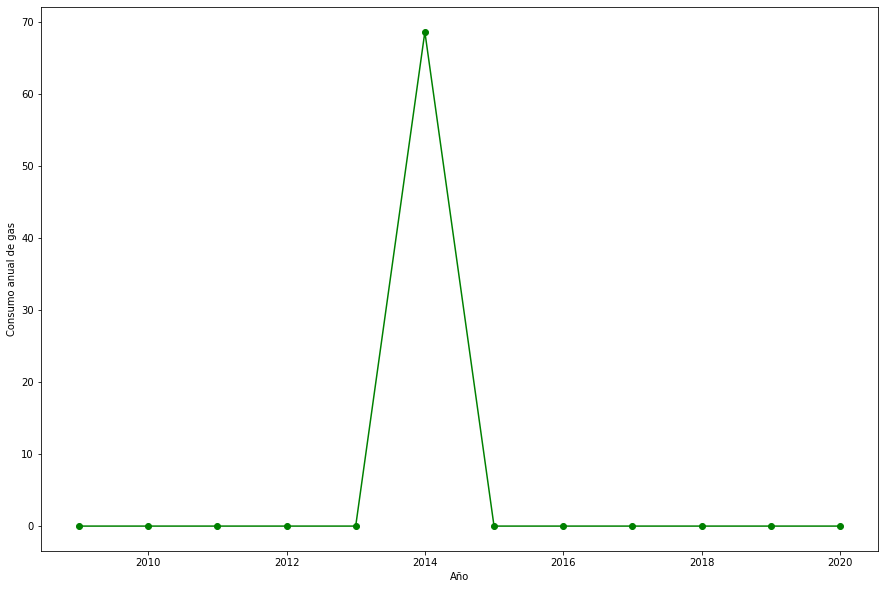

In [ ]:
p_2009 = df_g2009['self_production'].mean()
p_2010 = df_g2010['self_production'].mean()
p_2011 = df_g2011['self_production'].mean()
p_2012 = df_g2012['self_production'].mean()
p_2013 = df_g2013['self_production'].mean()
p_2014 = df_g2014['self_production'].mean()
p_2015 = df_g2015['self_production'].mean()
p_2016 = df_g2016['self_production'].mean()
p_2017 = df_g2017['self_production'].mean()
p_2018 = df_g2018['self_production'].mean()
p_2019 = df_g2019['self_production'].mean()
p_2020 = df_g2020['self_production'].mean()

year = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

ar = [p_2009, p_2010, p_2011, p_2012, p_2013, p_2014, p_2015, p_2016, p_2017, p_2018, p_2019, p_2020]

plt.plot(year,ar, color='green', marker='o')
plt.xlabel('Año')
plt.ylabel('Auto-produccion de gas')
plt.show()

Con respecto a la autoproducción de gas, no a presentado desarrollo alguno en los últimos 11 años a excepción de 2014 donde presenta un pick. Esto puede deberse a una iniciativa fallida a empezar a autoproducir gas al ver que era bastante peligroso y difícil la autoproducción de gas, a diferencia de la de electricidad la cual es mucho más efectiva y sencilla

#**Pregunta 10**

Tipo de conexion predominante vs consumo x conexion y conexiones activas en 2020

In [ ]:
df_conexiones20 = df_electricity[['type_of_connection','year','annual_consume','perc_of_active_connections']]
df_conexiones20 = df_conexiones20[df_conexiones20["year"] == 2020]


df_conexiones20['perc_of_active_connections'] = pd.to_numeric(df_conexiones20['perc_of_active_connections'])
df_conexiones20 = df_conexiones20[df_conexiones20['perc_of_active_connections'] > 0]

df_conexiones20[['perc_of_active_connections']].dropna()

df_conexiones20['type_of_connection'].value_counts()

In [ ]:
df_conexiones20['type_of_connection'].value_counts().plot(kind='bar')

plt.ylabel('numero de conexiones')
plt.title('conexiones mas usadas')

In [ ]:
df_conexiones20

In [ ]:
df_conexiones20 = df_conexiones20.groupby('type_of_connection').agg({
    'annual_consume' : 'sum',
    'perc_of_active_connections' : 'mean'
}).sort_values(by='annual_consume',ascending=False)

df_conexiones20

Viendo el tipo de conexiones utilizadas, nos dimos cuenta que hay 3 que predominan en el mercado, 1x35, 3x25 y 1x15. Siendo 1x35 la con más conexiones activas con 171856, el tipo de conexión 3x25 que lo sigue en volumen cuenta con 107579, sin embargo al revisar el consumo anual vemos que la 3x25 supera por más de un punto a la 1x35, siendo esta una mejor opción para invertir.